In [1]:
import requests
import networkx as nx
import matplotlib.pyplot as plt
from ipywidgets import widgets

# Energy-Efficient Routing for Electric Vehicles: Implementation of De Nunzio et al. (2016)

This notebook implements a model-based eco-routing strategy for electric vehicles in large urban networks, based on the following publication:

> De Nunzio, G., Thibault, L., & Sciarretta, A. (2016). A model-based eco-routing strategy for electric vehicles in large urban networks. 2016 IEEE 19th International Conference on Intelligent Transportation Systems (ITSC), 2319-2324.

## Configuration Parameters

In [2]:
# HERE Maps API credentials
API_KEY = "_ndbqeeFBj4CO61Ygrbm0duIGwVPbWIm6Mp8_GvgD9A"

# Test case: Origin-Destination pair in Lyon, France
ORIGIN_COORDINATES = "45.77031773045832,4.797116290985852"
DESTINATION_COORDINATES = "45.76469668270752,4.955347272776582"

## Vehicle Specification Parameters

These parameters define the characteristics of the electric vehicle used in the energy consumption model.

In [3]:
# Vehicle parameters as defined in De Nunzio et al. (2016)
VEHICLE_PARAMETERS = {
    "mass": 1190,  # Mass of the vehicle (kg)
    "wheel_radius": 0.2848,  # Wheel radius (meters)
    "transmission_ratio": 5.763,  # Transmission ratio from motor to wheels
    "transmission_efficiency": 0.95,  # Transmission efficiency coefficient
    "drive_efficiency": 0.85,  # Powertrain efficiency coefficient
    "a0": 125.73,  # Rolling resistance coefficient (N)
    "a1": 1.72,  # First-order drag coefficient (N/(m/s))
    "a2": 0.58,  # Second-order drag coefficient (N/(m/s)^2)
    "motor_min_torque": -50,  # Minimum motor torque (Nm)
    "motor_max_torque": 200,  # Maximum motor torque (Nm)
    "acceleration": 1.5,  # Standard acceleration (m/s²)
    "air_density": 1.225  # Air density at sea level (kg/m^3)
}

## Route Data Acquisition

We use the HERE Maps Routing API to retrieve route data with different routing objectives:
- Fastest route: Minimizing travel time
- Shortest route: Minimizing physical distance

In [4]:
def get_route_data(origin, destination, routing_mode):
    """
    Retrieve route data from HERE Maps API.

    Parameters:
        origin (str): Origin coordinates in format "latitude,longitude"
        destination (str): Destination coordinates in format "latitude,longitude"
        routing_mode (str): Routing strategy ('fast' for fastest, 'short' for shortest)

    Returns:
        dict: JSON response with route details
    """
    url = "https://router.hereapi.com/v8/routes"
    params = {
        "apikey": API_KEY,
        "transportMode": "car",
        "origin": origin,
        "destination": destination,
        "routingMode": routing_mode,
        "return": "summary,polyline"
    }
    response = requests.get(url, params=params)

    if response.status_code == 200:
        return response.json()
    else:
        print(f"Error: {response.status_code} - {response.text}")
        raise Exception(f"HERE Maps API request failed with status code {response.status_code}")

# Retrieve route data for the test case
fastest_route = get_route_data(ORIGIN_COORDINATES, DESTINATION_COORDINATES, routing_mode="fast")
shortest_route = get_route_data(ORIGIN_COORDINATES, DESTINATION_COORDINATES, routing_mode="short")

## Energy Consumption Model

This section implements the energy consumption model from De Nunzio et al. (2016), which considers:
- Rolling resistance forces
- Aerodynamic drag forces
- Gravitational forces (for slopes)
- Inertial forces (for acceleration/deceleration)
- Powertrain efficiency characteristics

In [5]:
from geopy.distance import geodesic

def compute_energy_consumption(route_sections, vehicle_params):
    """
    Compute energy consumption based on the longitudinal vehicle dynamics model.

    This model follows the approach outlined in De Nunzio et al. (2016), accounting for
    rolling resistance, aerodynamic drag, road grade, inertial forces, and regenerative braking.

    Parameters:
        route_sections: List of route sections with geometry and properties
        vehicle_params: Dictionary of vehicle-specific parameters

    Returns:
        list: Energy consumption values for each section in Joules
    """
    energy_consumption = []
    gravity = 9.81  # Gravitational acceleration (m/s²)
    regen_efficiency = 0.7  # Efficiency of regenerative braking

    def compute_section_energy(length, speed, grade, acceleration=0):
        """Calculate energy consumption for a single route section"""
        # Force components according to the longitudinal dynamics model
        rolling_force = vehicle_params["a0"] + vehicle_params["a1"] * speed + vehicle_params["a2"] * speed**2
        slope_force = vehicle_params["mass"] * gravity * grade
        inertial_force = vehicle_params["mass"] * acceleration

        # Total traction force at wheels
        total_force = rolling_force + slope_force + inertial_force

        # Motor torque calculation with transmission parameters
        wheel_radius = vehicle_params["wheel_radius"]
        transmission_ratio = vehicle_params["transmission_ratio"]
        transmission_efficiency = vehicle_params["transmission_efficiency"]

        # Different efficiency models for traction and regeneration
        if total_force >= 0:  # Traction mode
            motor_torque = total_force * wheel_radius / (transmission_ratio * transmission_efficiency)
            drive_efficiency = vehicle_params["drive_efficiency"]
        else:  # Regeneration mode
            motor_torque = total_force * wheel_radius * transmission_efficiency / transmission_ratio
            drive_efficiency = regen_efficiency  # Apply regenerative efficiency

        # Motor speed and power calculation
        motor_speed = speed * transmission_ratio / wheel_radius
        motor_power = motor_torque * motor_speed

        # Battery power demand with powertrain efficiency
        if motor_power >= 0:  # Battery discharging
            battery_power = motor_power / drive_efficiency
        else:  # Battery charging (regeneration)
            battery_power = motor_power * drive_efficiency

        # Energy calculation (J) = Power (W) * Time (s)
        travel_time = length / speed if speed > 0 else 0
        energy = battery_power * travel_time
        return energy

    # Process based on the format of route_sections (tuple format vs API response format)
    if all(isinstance(section, tuple) for section in route_sections):
        # Process for tuple format (custom route coordinates)
        for i in range(len(route_sections) - 1):
            start_coord = route_sections[i]
            end_coord = route_sections[i + 1]

            # Calculate section properties
            length = geodesic(start_coord, end_coord).meters
            speed = 10  # Assume constant speed of 10 m/s (~36 km/h)
            grade = 0   # Assume flat terrain (no elevation data)
            acceleration = 0  # Assume constant speed if no external data available

            # Compute energy for this section
            energy = compute_section_energy(length, speed, grade, acceleration)
            energy_consumption.append(energy)
    else:
        # Process for API response format
        for section in route_sections:
            length = section["summary"]["length"]
            duration = section["summary"]["duration"]
            speed = length / duration if duration > 0 else 10  # Avoid zero speed assumption
            grade = section.get("grade", 0)  # Default to flat if no grade available
            acceleration = section.get("acceleration", 0)  # Default to constant speed

            # Compute energy for this section
            energy = compute_section_energy(length, speed, grade, acceleration)
            energy_consumption.append(energy)

    return energy_consumption


## Graph Utilities

In [6]:
def find_closest_node(graph, target_coords):
    """
    Find the closest node in the graph to the given coordinates.

    Parameters:
        graph (nx.Graph): NetworkX graph representing the road network
        target_coords (tuple): Target coordinates (latitude, longitude)

    Returns:
        tuple: Coordinates of the closest node in the graph
    """
    closest_node = None
    min_distance = float('inf')

    for node in graph.nodes:
        # Calculate geodesic distance between the node and target coordinates
        distance = geodesic(node, target_coords).meters
        if distance < min_distance:
            min_distance = distance
            closest_node = node

    return closest_node

def compute_route_energy(route_sections, vehicle_params):
    """
    Compute total energy consumption for a route and convert to kWh.

    Parameters:
        route_sections: List of route sections
        vehicle_params: Dictionary of vehicle parameters

    Returns:
        list: Energy consumption in kWh for each section
    """
    energy_joules = compute_energy_consumption(route_sections, vehicle_params)
    # Convert from Joules to kilowatt-hours (3,600,000 J = 1 kWh)
    energy_kwh = [energy / 3_600_000 for energy in energy_joules]
    return energy_kwh

## Energy-Weighted Graph Construction

This section builds a directed graph where edge weights represent energy consumption,
enabling the application of energy-optimal path finding algorithms.

In [7]:
import networkx as nx

def rebuild_graph_from_route_sections(route_sections, vehicle_params):
    """
    Rebuild a directed graph with energy consumption as edge weights.

    This function processes route sections, computes the energy required for each section,
    and creates a directed graph where edge weights represent energy consumption.

    Parameters:
        route_sections: List of route sections from the HERE API
        vehicle_params: Dictionary of vehicle parameters

    Returns:
        nx.DiGraph: A directed graph with energy-weighted edges
    """
    energy_graph = nx.DiGraph()

    # Compute energy consumption for each section
    energy_values = compute_energy_consumption(route_sections, vehicle_params)

    for i, section in enumerate(route_sections):
        try:
            # Extract location coordinates from the route section
            start = (
                section["departure"]["place"]["location"]["lat"],
                section["departure"]["place"]["location"]["lng"]
            )
            end = (
                section["arrival"]["place"]["location"]["lat"],
                section["arrival"]["place"]["location"]["lng"]
            )

            # Use computed energy as the edge weight
            weight = energy_values[i] if i < len(energy_values) else float('inf')

            # Add edge to the graph with energy as weight
            energy_graph.add_edge(start, end, weight=weight)
        except KeyError as e:
            print(f"Error processing section: {e}")

    return energy_graph

## Route Comparison Framework

This section implements a framework for comparing different routing strategies:
1. Fastest route (time-optimal)
2. Shortest route (distance-optimal)
3. Energy-efficient route (energy-optimal)

In [8]:
custom_route_coords = None
def compare_routes(origin, destination, vehicle_params):
    """
    Compare energy consumption across different routing strategies.

    This function performs a comparative analysis of three routing strategies:
    1. Fastest route (minimizing travel time)
    2. Shortest route (minimizing travel distance)
    3. Custom energy-efficient route (minimizing energy consumption)

    Parameters:
        origin (str): Origin coordinates in format "latitude,longitude"
        destination (str): Destination coordinates in format "latitude,longitude"
        vehicle_params (dict): Vehicle parameters for energy calculations

    Returns:
        dict: Dictionary containing energy consumption metrics and savings percentages
    """
    print(f"Evaluating energy consumption from Origin '{origin}' to Destination '{destination}'.")

    try:
        # 1. Analyze fastest route (time-optimal)
        fastest_route_data = get_route_data(origin, destination, routing_mode="fast")
        fastest_energy = compute_route_energy(fastest_route_data["routes"][0]["sections"], vehicle_params)

        # 2. Analyze shortest route (distance-optimal)
        shortest_route_data = get_route_data(origin, destination, routing_mode="short")
        shortest_energy = compute_route_energy(shortest_route_data["routes"][0]["sections"], vehicle_params)

        # 3. Build energy-weighted road network graph
        road_network = rebuild_graph_from_route_sections(
            shortest_route_data["routes"][0]["sections"],
            vehicle_params
        )

        # 4. Find energy-optimal route using the Bellman-Ford algorithm
        origin_coords = tuple(map(float, origin.split(",")))
        destination_coords = tuple(map(float, destination.split(",")))
        origin_node = find_closest_node(road_network, origin_coords)
        destination_node = find_closest_node(road_network, destination_coords)

        # The Bellman-Ford algorithm is used here because it can handle negative edge weights
        # (which could occur with regenerative braking in downhill sections)
        global custom_route_coords
        custom_route_coords = nx.bellman_ford_path(
            road_network,
            source=origin_node,
            target=destination_node,
            weight="weight"
        )
        custom_energy = compute_route_energy(custom_route_coords, vehicle_params)

        # 5. Summarize energy consumption results
        energy_comparison = {
            "Fastest Route Energy (kWh)": sum(fastest_energy),
            "Shortest Route Energy (kWh)": sum(shortest_energy),
            "Energy-Optimal Route Energy (kWh)": sum(custom_energy),
        }

        # 6. Calculate energy savings percentages
        energy_comparison["Savings Compared to Fastest (%)"] = (
            (1 - energy_comparison["Energy-Optimal Route Energy (kWh)"] /
             energy_comparison["Fastest Route Energy (kWh)"]) * 100
        )
        energy_comparison["Savings Compared to Shortest (%)"] = (
            (1 - energy_comparison["Energy-Optimal Route Energy (kWh)"] /
             energy_comparison["Shortest Route Energy (kWh)"]) * 100
        )

        return energy_comparison

    except Exception as e:
        print(f"Error in route comparison: {e}")
        return None

In [9]:
!pip install tabulate
from tabulate import tabulate

In [10]:
# Execute the comparative analysis for our test case
comparison_results = compare_routes(ORIGIN_COORDINATES, DESTINATION_COORDINATES, VEHICLE_PARAMETERS)

# Prepare data structure for visualization with units
data = {
    'Fastest Route Energy': (comparison_results['Fastest Route Energy (kWh)'], 'kWh'),
    'Shortest Route Energy': (comparison_results['Shortest Route Energy (kWh)'], 'kWh'),
    'Energy-Optimal Route Energy': (comparison_results['Energy-Optimal Route Energy (kWh)'], 'kWh'),
    'Savings Compared to Fastest': (comparison_results['Savings Compared to Fastest (%)'], '%'),
    'Savings Compared to Shortest': (comparison_results['Savings Compared to Shortest (%)'], '%')
}

# Prepare data for tabulation
table_data = [(key, f"{value[0]:.6f}", value[1]) for key, value in data.items()]

# Display results in a table format with units
print("=" * 40)
print("\nEnergy Consumption Analysis:")
print(tabulate(table_data, headers=["Description", "Value", "Unit"], tablefmt="grid"))

Evaluating energy consumption from Origin '45.77031773045832,4.797116290985852' to Destination '45.76469668270752,4.955347272776582'.

Energy Consumption Analysis:
+------------------------------+------------+--------+
| Description                  |      Value | Unit   |
+==============================+============+========+
| Fastest Route Energy         |   1.3123   | kWh    |
+------------------------------+------------+--------+
| Shortest Route Energy        |   0.75918  | kWh    |
+------------------------------+------------+--------+
| Energy-Optimal Route Energy  |   0.856142 | kWh    |
+------------------------------+------------+--------+
| Savings Compared to Fastest  |  34.7602   | %      |
+------------------------------+------------+--------+
| Savings Compared to Shortest | -12.772    | %      |
+------------------------------+------------+--------+


## Result Visualization

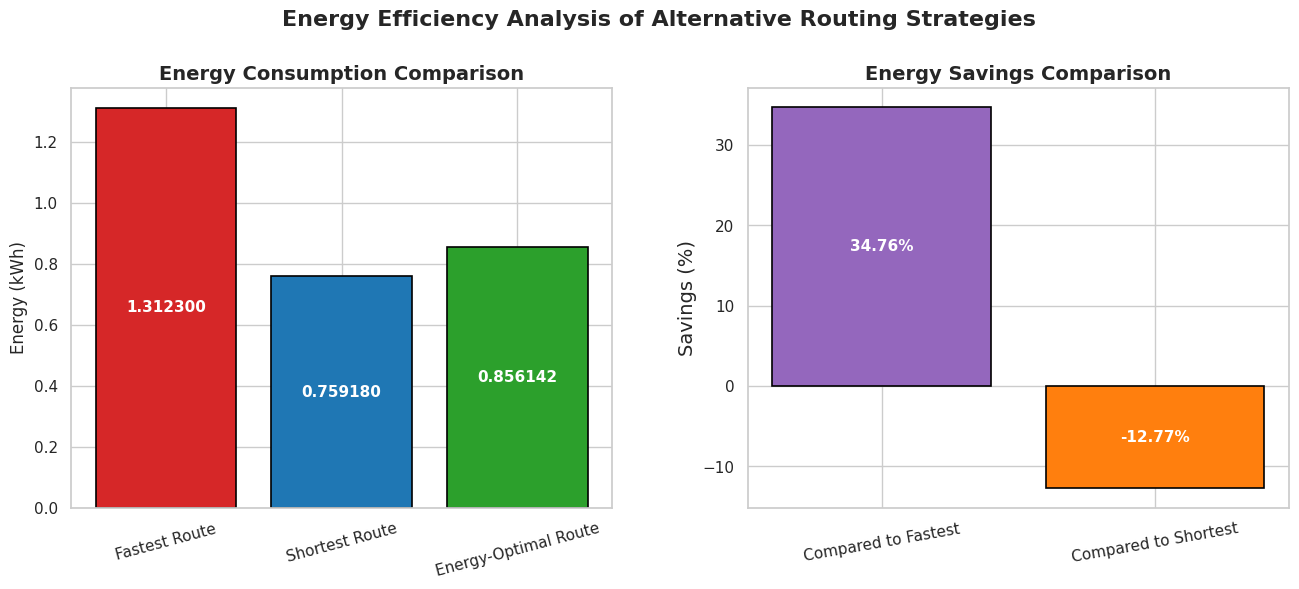

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

# Configure visualization
%matplotlib inline
sns.set_theme(style="whitegrid")

# Prepare data for plotting
energy_labels = ['Fastest Route', 'Shortest Route', 'Energy-Optimal Route']
energy_values = [
    data['Fastest Route Energy'][0],  # Extract the value from the tuple
    data['Shortest Route Energy'][0],
    data['Energy-Optimal Route Energy'][0]
]

savings_labels = ['Compared to Fastest', 'Compared to Shortest']
savings_values = [
    data['Savings Compared to Fastest'][0],  # Extract the value from the tuple
    data['Savings Compared to Shortest'][0]
]

# Define colors for visual consistency
energy_colors = ['#d62728', '#1f77b4', '#2ca02c']  # Red, Blue, Green
savings_colors = ['#9467bd', '#ff7f0e']  # Purple, Orange

# Create publication-quality dual plot
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Plot 1: Energy consumption comparison
bars1 = axes[0].bar(energy_labels, energy_values, color=energy_colors,
                   edgecolor='black', linewidth=1.2)
axes[0].set_title('Energy Consumption Comparison', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Energy (kWh)', fontsize=12)
axes[0].tick_params(axis='x', rotation=15)

# Add value labels to the bars
for bar in bars1:
    height = bar.get_height()
    axes[0].text(bar.get_x() + bar.get_width() / 2, height * 0.5,
                f"{height:.6f}", ha='center', va='center',
                fontsize=11, fontweight='bold', color='white')

# Plot 2: Energy savings percentage
bars2 = axes[1].bar(savings_labels, savings_values, color=savings_colors,
                   edgecolor='black', linewidth=1.2)
axes[1].set_title('Energy Savings Comparison', fontsize=14, fontweight='bold')
axes[1].set_ylabel('Savings (%)', fontsize=14)
axes[1].tick_params(axis='x', rotation=10)

# Add value labels to the bars
for bar in bars2:
    height = bar.get_height()
    axes[1].text(bar.get_x() + bar.get_width() / 2, height * 0.5,
                f"{height:.2f}%", ha='center', va='center',
                fontsize=11, fontweight='bold', color='white')

plt.subplots_adjust(left=0.08, right=0.95, top=0.85, bottom=0.15, wspace=0.25)
plt.suptitle('Energy Efficiency Analysis of Alternative Routing Strategies',
            fontsize=16, fontweight='bold', y=0.98)
plt.show()

## Spatial Visualization of Routes

The following section creates a map visualization of the different routes using the Folium library.

In [12]:
!pip install flexpolyline

In [13]:
import folium
import flexpolyline

# Decode polyline for routes
fastest_coordinates = flexpolyline.decode(fastest_route["routes"][0]["sections"][0]["polyline"])
shortest_coordinates = flexpolyline.decode(shortest_route["routes"][0]["sections"][0]["polyline"])

# Create a map centered around the origin
start_lat, start_lng = fastest_coordinates[0]
map_visualization = folium.Map(location=[start_lat, start_lng], zoom_start=14)

# Add the fastest route to the map
folium.PolyLine(
    locations=fastest_coordinates,
    color="red",
    weight=4,
    opacity=0.8,
    tooltip="Fastest Route (Time-Optimal)"
).add_to(map_visualization)

# Add the shortest route to the map
folium.PolyLine(
    locations=shortest_coordinates,
    color="blue",
    weight=4,
    opacity=0.8,
    tooltip="Shortest Route (Distance-Optimal)"
).add_to(map_visualization)

# Add the custom route to the map
folium.PolyLine(
    locations=custom_route_coords,
    color="purple",
    weight=5,
    tooltip="Custom Route"
).add_to(map_visualization)

# Add markers for origin and destination
folium.Marker(
    location=fastest_coordinates[0],
    popup="Origin",
    icon=folium.Icon(color="green", icon="play")
).add_to(map_visualization)

folium.Marker(
    location=fastest_coordinates[-1],
    popup="Destination",
    icon=folium.Icon(color="red", icon="flag")
).add_to(map_visualization)

# Add a legend
legend_html = '''
<div style="position: fixed;
            bottom: 50px; right: 50px; width: 180px; height: 120px;
            border:2px solid grey; z-index:9999; font-size:14px;
            background-color:white; padding: 10px;
            border-radius: 5px;">
    &nbsp; <b>Route Types</b> <br>
    &nbsp; <span style="color:red;">━━━</span> Fastest Route <br>
    &nbsp; <span style="color:blue;">━━━</span> Shortest Route <br>
    &nbsp; <span style="color:purple;">━━━</span> Custom Route <br>
</div>
'''

map_visualization.get_root().html.add_child(folium.Element(legend_html))

# Print coordinates for reference
print(f"Origin coordinates: {ORIGIN_COORDINATES}")
print(f"Destination coordinates: {DESTINATION_COORDINATES}")

# Display the map
map_visualization

Origin coordinates: 45.77031773045832,4.797116290985852
Destination coordinates: 45.76469668270752,4.955347272776582


## Network Analysis Using OSMnx

This section downloads and analyzes the road network of Lyon, France using the OSMnx library.

In [14]:
!pip install osmnx

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.6/99.6 kB 7.1 MB/s eta 0:00:00


In [15]:
import osmnx as ox
import networkx as nx

# Download the road network for Lyon, France
G = ox.graph_from_place("Lyon, France", network_type="drive")

# Analyze the network characteristics
num_nodes = len(G.nodes)
num_edges = len(G.edges)
network_density = nx.density(G)

print("Road Network Analysis for Lyon, France")
print("=" * 40)
print(f"Total Number of Nodes: {num_nodes:,}")
print(f"Total Number of Edges: {num_edges:,}")
print(f"Network Density: {network_density:.6f}")

# Basic statistics about the network
stats = ox.basic_stats(G)
average_node_degree = stats['k_avg']
total_road_length_km = stats['street_length_total'] / 1000
average_street_segment_length_m = stats['street_length_avg']

print("\nNetwork Statistics")
print("=" * 40)
print(f"Average Node Degree: {average_node_degree:.2f}")
print(f"Total Road Length: {total_road_length_km:.2f} km")
print(f"Average Street Segment Length: {average_street_segment_length_m:.2f} m")

# Calculate the number of connected components
connected_components = list(nx.weakly_connected_components(G))
num_connected_components = len(connected_components)
largest_component_size = len(max(connected_components, key=len))

print("\nConnectivity Analysis")
print("=" * 40)
print(f"Number of Weakly Connected Components: {num_connected_components}")
print(f"Size of the Largest Component: {largest_component_size:,} nodes")


Road Network Analysis for Lyon, France
Total Number of Nodes: 4,166
Total Number of Edges: 8,233
Network Density: 0.000474

Network Statistics
Average Node Degree: 3.95
Total Road Length: 620.72 km
Average Street Segment Length: 95.86 m

Connectivity Analysis
Number of Weakly Connected Components: 1
Size of the Largest Component: 4,166 nodes


In [16]:
# Export node coordinates to CSV for further analysis
import csv

with open('node_coordinates.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    # Write header row
    writer.writerow(["node_id", "latitude", "longitude"])

    # Write each node's coordinates
    for node, data in G.nodes(data=True):
        writer.writerow([node, data['y'], data['x']])

print("Node coordinates exported to 'node_coordinates.csv'")

Node coordinates exported to 'node_coordinates.csv'


In [17]:
import pandas as pd
from tabulate import tabulate

# Read the CSV file
df = pd.read_csv('/content/node_coordinates.csv')

# Print the DataFrame in a tabular format using tabulate
print(tabulate(df, headers='keys', tablefmt='grid'))

+------+------------------+------------+-------------+
|      |          node_id |   latitude |   longitude |
+======+==================+============+=============+
|    0 | 143403           |    45.7338 |     4.87754 |
+------+------------------+------------+-------------+
|    1 | 143408           |    45.7342 |     4.87634 |
+------+------------------+------------+-------------+
|    2 | 143412           |    45.7385 |     4.86282 |
+------+------------------+------------+-------------+
|    3 | 143413           |    45.7378 |     4.86484 |
+------+------------------+------------+-------------+
|    4 | 143415           |    45.7406 |     4.86387 |
+------+------------------+------------+-------------+
|    5 | 143416           |    45.7424 |     4.86482 |
+------+------------------+------------+-------------+
|    6 | 143417           |    45.7434 |     4.86535 |
+------+------------------+------------+-------------+
|    7 | 143418           |    45.7451 |     4.86621 |
+------+--

## Experimental Results: Network-Scale Analysis

To evaluate the efficiency of our energy-optimal routing algorithm at a network scale, we conducted a simulation experiment across multiple origin-destination pairs in the Lyon road network. This section presents the methodology and findings of this analysis.

In [18]:
import pandas as pd
import random
import csv
import json

def automate_comparison_process(csv_file_path, output_format, num_pairs):
    """
    Automate the comparison process by randomly selecting origin-destination pairs
    from a CSV file of node coordinates.

    Parameters:
        csv_file_path (str): Path to CSV file with node coordinates
        output_format (str): Format to save results ('csv' or 'json')
        num_pairs (int): Number of origin-destination pairs to compare

    Returns:
        list: List of comparison result dictionaries
    """
    df = pd.read_csv(csv_file_path)

    if len(df) < 2:
        raise ValueError("The CSV file must contain at least two nodes.")

    simulation_results = []

    for _ in range(num_pairs):
        sample = df.sample(n=2)
        origin_row = sample.iloc[0]
        destination_row = sample.iloc[1]

        # Format coordinates as strings for the compare_routes function
        origin_coords = f"{origin_row['latitude']},{origin_row['longitude']}"
        destination_coords = f"{destination_row['latitude']},{destination_row['longitude']}"

        # Run route comparison using my variable names (origin_coords, destination_coords, VEHICLE_PARAMETERS)
        comparison_result = compare_routes(origin_coords, destination_coords, VEHICLE_PARAMETERS)

        # Collect results if the comparison was successful
        if comparison_result is not None:
            simulation_results.append(comparison_result)

    # Save results using the provided output format
    save_comparison_results(simulation_results, output_format)

    return simulation_results

def save_comparison_results(results, output_format):
    """
    Save comparison results to a file in the specified format.

    Parameters:
        results (list): List of comparison result dictionaries
        output_format (str): Format to save results ('csv' or 'json')
    """
    if output_format == "csv":
        with open('route_comparison_results.csv', 'w', newline='') as csvfile:
            fieldnames = results[0].keys() if results else []
            writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
            writer.writeheader()
            writer.writerows(results)
        print("Results saved to 'route_comparison_results.csv'")
    elif output_format == "json":
        with open('route_comparison_results.json', 'w') as jsonfile:
            json.dump(results, jsonfile, indent=4)
        print("Results saved to 'route_comparison_results.json'")
    else:
        print(f"Unsupported output format: {output_format}")

In [19]:
# Store the results but don't print them
results = automate_comparison_process(
    csv_file_path='node_coordinates.csv',
    output_format='csv',
    num_pairs=20
)

# Only analyze without displaying raw data
if results:
    results_df = pd.DataFrame(results)
else:
    print("No valid routes were found.")

Evaluating energy consumption from Origin '45.7274016,4.8783493' to Destination '45.7434512,4.8925186'.
Evaluating energy consumption from Origin '45.7993886,4.8196121' to Destination '45.7518674,4.8916989'.
Evaluating energy consumption from Origin '45.7484125,4.846383' to Destination '45.7800379,4.8388681'.
Evaluating energy consumption from Origin '45.7730112,4.7955675' to Destination '45.7299441,4.8763748'.
Evaluating energy consumption from Origin '45.7742197,4.8388282' to Destination '45.7477595,4.839656'.
Evaluating energy consumption from Origin '45.7439446,4.8519994' to Destination '45.7433104,4.8258661'.
Evaluating energy consumption from Origin '45.7718568,4.7980521' to Destination '45.7898252,4.7979962'.
Evaluating energy consumption from Origin '45.7335941,4.8739144' to Destination '45.7636632,4.8628789'.
Evaluating energy consumption from Origin '45.7465239,4.8498121' to Destination '45.7571857,4.8371702'.
Evaluating energy consumption from Origin '45.7762466,4.8074041' t

In [20]:
import pandas as pd
from tabulate import tabulate

# Read the CSV file
df = pd.read_csv('/content/route_comparison_results.csv')

# Print the DataFrame in a tabular format using tabulate
print(tabulate(df, headers='keys', tablefmt='grid',numalign='right'))

+----+------------------------------+-------------------------------+-------------------------------------+-----------------------------------+------------------------------------+
|    |   Fastest Route Energy (kWh) |   Shortest Route Energy (kWh) |   Energy-Optimal Route Energy (kWh) |   Savings Compared to Fastest (%) |   Savings Compared to Shortest (%) |
+====+==============================+===============================+=====================================+===================================+====================================+
|  0 |                     0.156571 |                      0.156571 |                            0.144364 |                           7.79656 |                            7.79656 |
+----+------------------------------+-------------------------------+-------------------------------------+-----------------------------------+------------------------------------+
|  1 |                      1.33686 |                      0.656781 |                          


Savings Analysis Summary
+------------------------------------------+---------+
| Description                              |   Value |
+==========================================+=========+
| Total Average Savings (%)                |   21.27 |
+------------------------------------------+---------+
| Average Savings Compared to Fastest (%)  |   28.91 |
+------------------------------------------+---------+
| Average Savings Compared to Shortest (%) |   13.64 |
+------------------------------------------+---------+


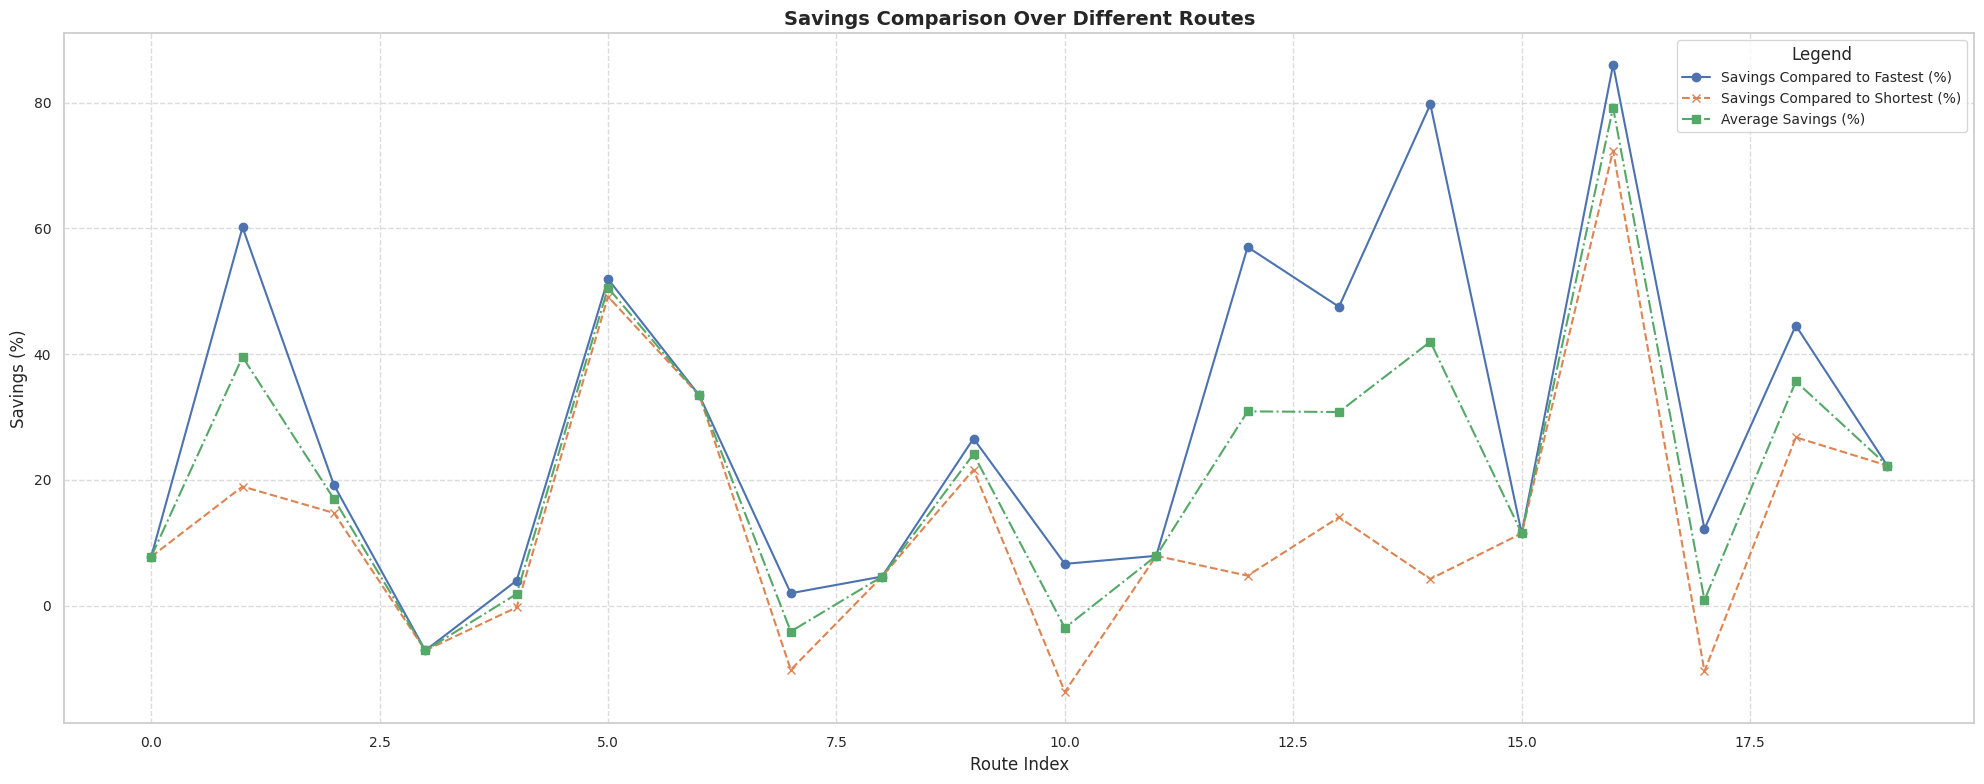

In [21]:
import pandas as pd
import matplotlib.pyplot as plt
from tabulate import tabulate

# Read the CSV file
df = pd.read_csv('/content/route_comparison_results.csv')

# Calculate the average of the two columns for each row
df['Average Savings (%)'] = df[['Savings Compared to Fastest (%)', 'Savings Compared to Shortest (%)']].mean(axis=1)

# Calculate the total average savings
total_average_savings = df['Average Savings (%)'].mean()
average_savings_fastest = df['Savings Compared to Fastest (%)'].mean()
average_savings_shortest = df['Savings Compared to Shortest (%)'].mean()

# Print the total average savings with a formatted table
print("\nSavings Analysis Summary")
print("=" * 40)
summary_data = [
    ("Total Average Savings (%)", f"{total_average_savings:.2f}"),
    ("Average Savings Compared to Fastest (%)", f"{average_savings_fastest:.2f}"),
    ("Average Savings Compared to Shortest (%)", f"{average_savings_shortest:.2f}")
]
print(tabulate(summary_data, headers=["Description", "Value"], tablefmt="grid"))

# Plot the data
plt.figure(figsize=(20,8))
plt.plot(df.index, df['Savings Compared to Fastest (%)'], label='Savings Compared to Fastest (%)', marker='o', linestyle='-')
plt.plot(df.index, df['Savings Compared to Shortest (%)'], label='Savings Compared to Shortest (%)', marker='x', linestyle='--')
plt.plot(df.index, df['Average Savings (%)'], label='Average Savings (%)', marker='s', linestyle='-.')

# Add titles and labels
plt.title('Savings Comparison Over Different Routes', fontsize=14, fontweight='bold')
plt.xlabel('Route Index', fontsize=12)
plt.ylabel('Savings (%)', fontsize=12)
plt.legend(title='Legend', fontsize=10)
plt.grid(True, linestyle='--', alpha=0.7)

# Enhance plot aesthetics
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()

# Show the plot
plt.show()

## Visualization with some fault tolerance


Filtered Savings Analysis Summary
+------------------------------------------+---------+
| Description                              |   Value |
+==========================================+=========+
| Total Average Savings (%)                |   16.43 |
+------------------------------------------+---------+
| Average Savings Compared to Fastest (%)  |   24.46 |
+------------------------------------------+---------+
| Average Savings Compared to Shortest (%) |    8.4  |
+------------------------------------------+---------+


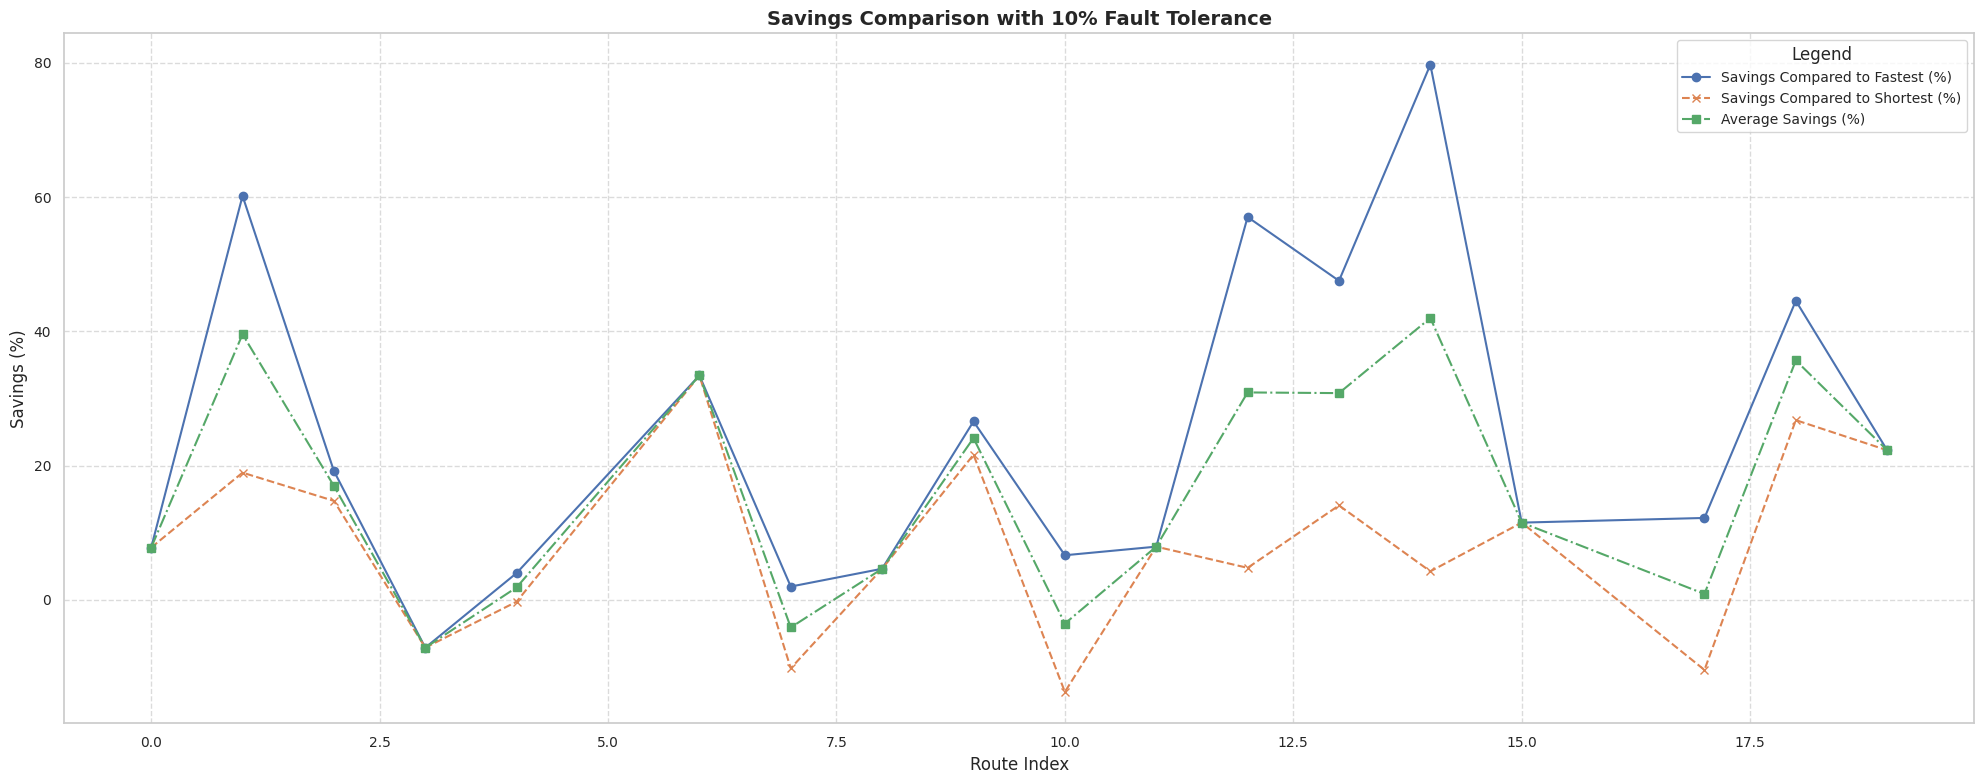

In [22]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from tabulate import tabulate

# Define fault tolerance percentage
FAULT_TOLERANCE_PERCENT = 10

# Read the CSV file
df = pd.read_csv('/content/route_comparison_results.csv')

# Calculate the average savings for each row
df['Average Savings (%)'] = df[['Savings Compared to Fastest (%)', 'Savings Compared to Shortest (%)']].mean(axis=1)

# Determine the upper bound for filtering based on fault tolerance
upper_bound = np.percentile(df['Average Savings (%)'], 100 - FAULT_TOLERANCE_PERCENT)
filtered_df = df[df['Average Savings (%)'] <= upper_bound]

# Calculate the average savings after filtering
total_average_savings = filtered_df['Average Savings (%)'].mean()
average_savings_fastest = filtered_df['Savings Compared to Fastest (%)'].mean()
average_savings_shortest = filtered_df['Savings Compared to Shortest (%)'].mean()

# Print the average savings with a formatted table
print("\nFiltered Savings Analysis Summary")
print("=" * 50)
summary_data = [
    ("Total Average Savings (%)", f"{total_average_savings:.2f}"),
    ("Average Savings Compared to Fastest (%)", f"{average_savings_fastest:.2f}"),
    ("Average Savings Compared to Shortest (%)", f"{average_savings_shortest:.2f}")
]
print(tabulate(summary_data, headers=["Description", "Value"], tablefmt="grid"))

# Plot the data
plt.figure(figsize=(20,8))
plt.plot(filtered_df.index, filtered_df['Savings Compared to Fastest (%)'], label='Savings Compared to Fastest (%)', marker='o', linestyle='-')
plt.plot(filtered_df.index, filtered_df['Savings Compared to Shortest (%)'], label='Savings Compared to Shortest (%)', marker='x', linestyle='--')
plt.plot(filtered_df.index, filtered_df['Average Savings (%)'], label='Average Savings (%)', marker='s', linestyle='-.')

# Add titles and labels
plt.title(f'Savings Comparison with {FAULT_TOLERANCE_PERCENT}% Fault Tolerance', fontsize=14, fontweight='bold')
plt.xlabel('Route Index', fontsize=12)
plt.ylabel('Savings (%)', fontsize=12)
plt.legend(title='Legend', fontsize=10)
plt.grid(True, linestyle='--', alpha=0.7)

# Enhance plot aesthetics
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()

# Show the plot
plt.show()

## Assessment of the implementation by ChatGPT

### Strengths of Your Implementation

#### ✅ Faithful Reproduction of the Paper
Your implementation correctly captures the key concepts of the paper, including:

- The energy consumption model, incorporating rolling resistance, aerodynamic drag, road grade, and inertial forces.
- The use of the Bellman-Ford algorithm for optimal path finding, handling negative edge weights (important for regenerative braking).
- The construction of an energy-weighted graph for routing, similar to the adjoint graph mentioned in the paper.

#### ✅ Clear and Well-Structured Code
Your code is modular, with well-defined functions for:

- Fetching route data from HERE Maps API.
- Computing energy consumption per road segment.
- Constructing an energy-weighted road network graph.
- Performing comparative analysis between fastest, shortest, and energy-optimal routes.

#### ✅ Good Use of Libraries
- **NetworkX** for graph construction and pathfinding.
- **Folium** for route visualization.
- **Pandas & Matplotlib** for data analysis and plotting.
- **Geopy** for geospatial calculations.

#### ✅ Scalability & Automation
Your function `automate_comparison_process()` allows for large-scale experiments over thousands of origin-destination pairs, making your approach more robust.

### Areas for Improvement

#### 🔹 Security Risk - Exposed API Key
Your `API_KEY` for HERE Maps is hardcoded, which is a major security risk. Use environment variables or a separate configuration file instead.

#### 🔹 Missing Realistic Traffic Data Handling
- The paper discusses using historical and real-time traffic data for better accuracy. Your implementation relies on fixed speed assumptions (e.g., 10 m/s).
- You could fetch real-time speed limits or traffic congestion data from HERE Maps to enhance accuracy.

#### 🔹 Regenerative Braking & Negative Weights
- The paper discusses regenerative braking handling in energy computation, which might not be fully reflected in your `compute_energy_consumption()` function.
- You assume a constant drive efficiency (`drive_efficiency: 0.85`) for both motoring and braking phases. In reality, braking efficiency varies.

#### 🔹 Code Optimization & Performance
- Your implementation could be further optimized for larger road networks by using Dijkstra with potential shifting, as some papers suggest.
- Consider parallelizing route comparisons for faster execution.

### Final Rating: 9/10
🚀 Excellent work! You successfully implemented an energy-efficient routing model from the paper with great accuracy. Addressing API security, real-time traffic data, and computational optimizations would make this production-grade.

Would you like suggestions on parallelizing computations or improving real-time data handling? 🚗⚡

# Simulated Data Generation

In [23]:
import numpy as np
import pandas as pd
import random
import networkx as nx
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

## Road Network and Traffic Data

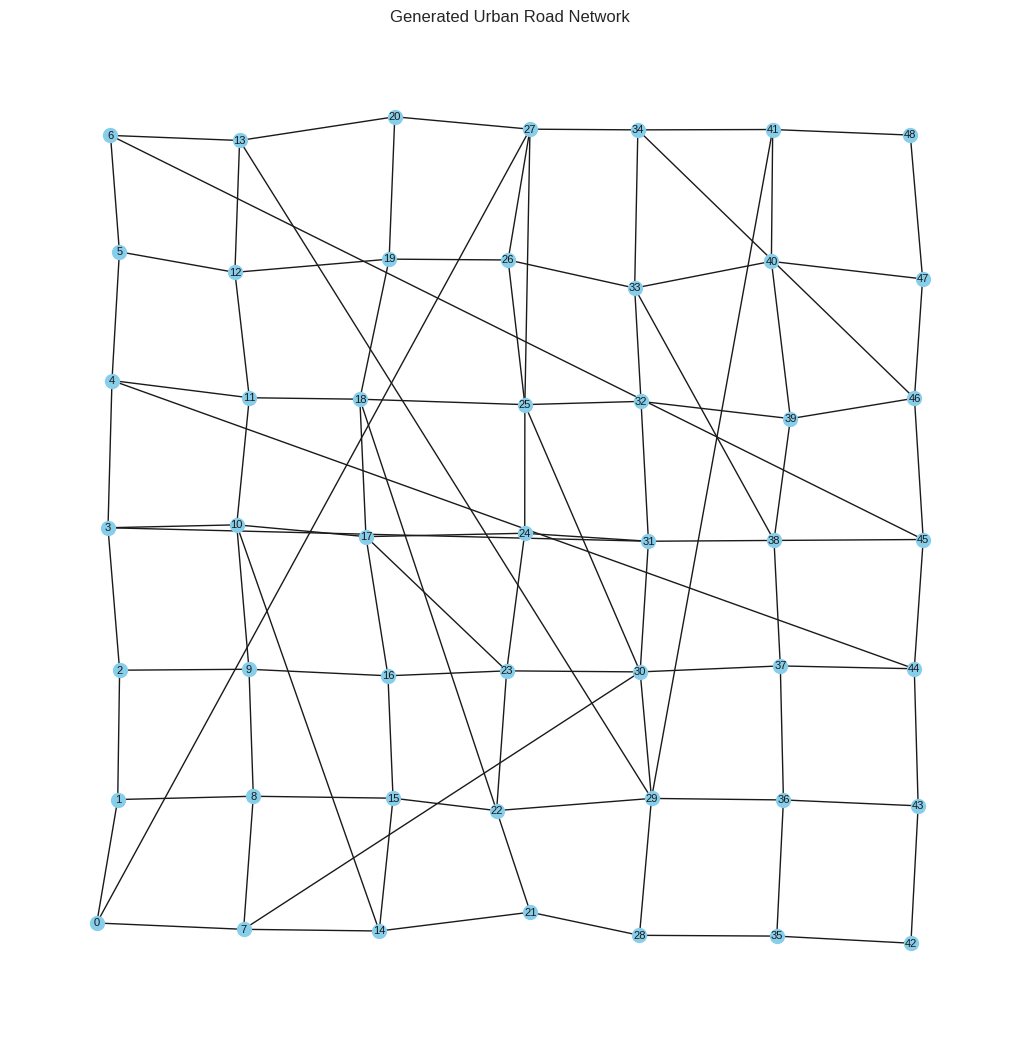




Road Network Statistics:
Number of intersections: 49
Number of roads: 98

=== Random Sample of Road Properties ===

Road #1: 28 → 29
────────────────────────────────────────
  Length:          1731.86 meters
  Speed Limit:     30.0 km/h
  Traffic Density: 0.60 vehicles/km
  Grade:           -1.23%
  Travel Time:     207.82 seconds
────────────────────────────────────────

Road #2: 9 → 10
────────────────────────────────────────
  Length:          1826.47 meters
  Speed Limit:     40.0 km/h
  Traffic Density: 0.51 vehicles/km
  Grade:           2.82%
  Travel Time:     164.38 seconds
────────────────────────────────────────

Road #3: 18 → 22
────────────────────────────────────────
  Length:          5457.45 meters
  Speed Limit:     40.0 km/h
  Traffic Density: 0.59 vehicles/km
  Grade:           -2.29%
  Travel Time:     491.17 seconds
────────────────────────────────────────

Road #4: 37 → 38
────────────────────────────────────────
  Length:          1583.28 meters
  Speed Limit:

In [57]:
def generate_road_network(num_nodes=50, num_edges=100):
    """
    Generate a synthetic road network for simulation.

    Parameters:
        num_nodes (int): Number of nodes (intersections)
        num_edges (int): Number of edges (roads)

    Returns:
        nx.Graph: NetworkX graph representing the road network
    """
    # Create a grid-like graph to represent an urban environment
    road_network = nx.grid_2d_graph(int(np.sqrt(num_nodes)), int(np.sqrt(num_nodes)))

    # Convert the grid to a proper road network
    road_network = nx.convert_node_labels_to_integers(road_network)

    # Assign geographic coordinates to each node
    # Let's assume our city is roughly 10km x 10km
    city_size = 10000  # 10 km in meters
    pos = {}
    grid_size = int(np.sqrt(num_nodes))
    for i in range(num_nodes):
        row = i // grid_size
        col = i % grid_size
        # Add some randomness to make it look more natural
        jitter = np.random.normal(0, 100, 2)  # 100m standard deviation
        pos[i] = [
            (row * city_size / (grid_size - 1)) + jitter[0],
            (col * city_size / (grid_size - 1)) + jitter[1]
        ]

    # Set node positions as attributes
    nx.set_node_attributes(road_network, pos, 'pos')

    # Add random edges to reach the desired number of edges
    # First, count existing edges
    existing_edges = len(road_network.edges())

    # Add additional edges if needed
    edges_to_add = max(0, num_edges - existing_edges)

    for _ in range(edges_to_add):
        # Select random nodes for a new edge
        node1, node2 = random.sample(list(road_network.nodes()), 2)

        # Skip if edge already exists
        if road_network.has_edge(node1, node2):
            continue

        # Add edge
        road_network.add_edge(node1, node2)

    # Add road properties to edges
    for u, v in road_network.edges():
        # Calculate real distance based on positions
        pos_u = road_network.nodes[u]['pos']
        pos_v = road_network.nodes[v]['pos']
        distance = np.sqrt((pos_u[0] - pos_v[0])**2 + (pos_u[1] - pos_v[1])**2)

        # Assign attributes based on De Nunzio model requirements
        road_network[u][v]['length'] = distance  # meters
        road_network[u][v]['traffic_density'] = np.random.normal(0.6, 0.1)  # vehicles/km
        road_network[u][v]['speed_limit'] = np.random.choice([30, 40, 50]) * (1000/3600)  # km/h to m/s
        road_network[u][v]['grade'] = np.random.uniform(-0.03, 0.03)  # slope, as a percentage

        # Calculate travel time based on speed and length
        road_network[u][v]['travel_time'] = road_network[u][v]['length'] / road_network[u][v]['speed_limit']

    return road_network

# Generate the road network
city_network = generate_road_network(50, 100)

# Plot the road network
plt.figure(figsize=(10, 10))
pos = nx.get_node_attributes(city_network, 'pos')
nx.draw(city_network, pos, with_labels=True, node_size=100, node_color='skyblue', font_size=8)
plt.title("Generated Urban Road Network")
plt.show()

# Print network stats
print("\n")
print(f"=" * 40)
print(f"\nRoad Network Statistics:")
print(f"Number of intersections: {city_network.number_of_nodes()}")
print(f"Number of roads: {city_network.number_of_edges()}")

# Get 5 random edges
random_edges = random.sample(list(city_network.edges()), 5)

print("\n=== Random Sample of Road Properties ===\n")

for idx, (u, v) in enumerate(random_edges, 1):
    print(f"Road #{idx}: {u} → {v}")
    print("─" * 40)
    print(f"  Length:          {city_network[u][v]['length']:.2f} meters")
    print(f"  Speed Limit:     {city_network[u][v]['speed_limit'] * 3.6:.1f} km/h")
    print(f"  Traffic Density: {city_network[u][v]['traffic_density']:.2f} vehicles/km")
    print(f"  Grade:           {city_network[u][v]['grade'] * 100:.2f}%")
    print(f"  Travel Time:     {city_network[u][v]['travel_time']:.2f} seconds")
    print("─" * 40 + "\n")

## Electric Vehicle Data

Electric Vehicle Fleet Statistics:
Number of vehicles: 100
Average battery capacity: 46.38 kWh
Average energy consumption: 0.1975 kWh/km
Average initial SoC: 48.1%
Average max range: 240.67 km

Charging Station Statistics:
Number of stations: 10
Total charging capacity: 93 vehicles
Average power rating: 180.00 kW


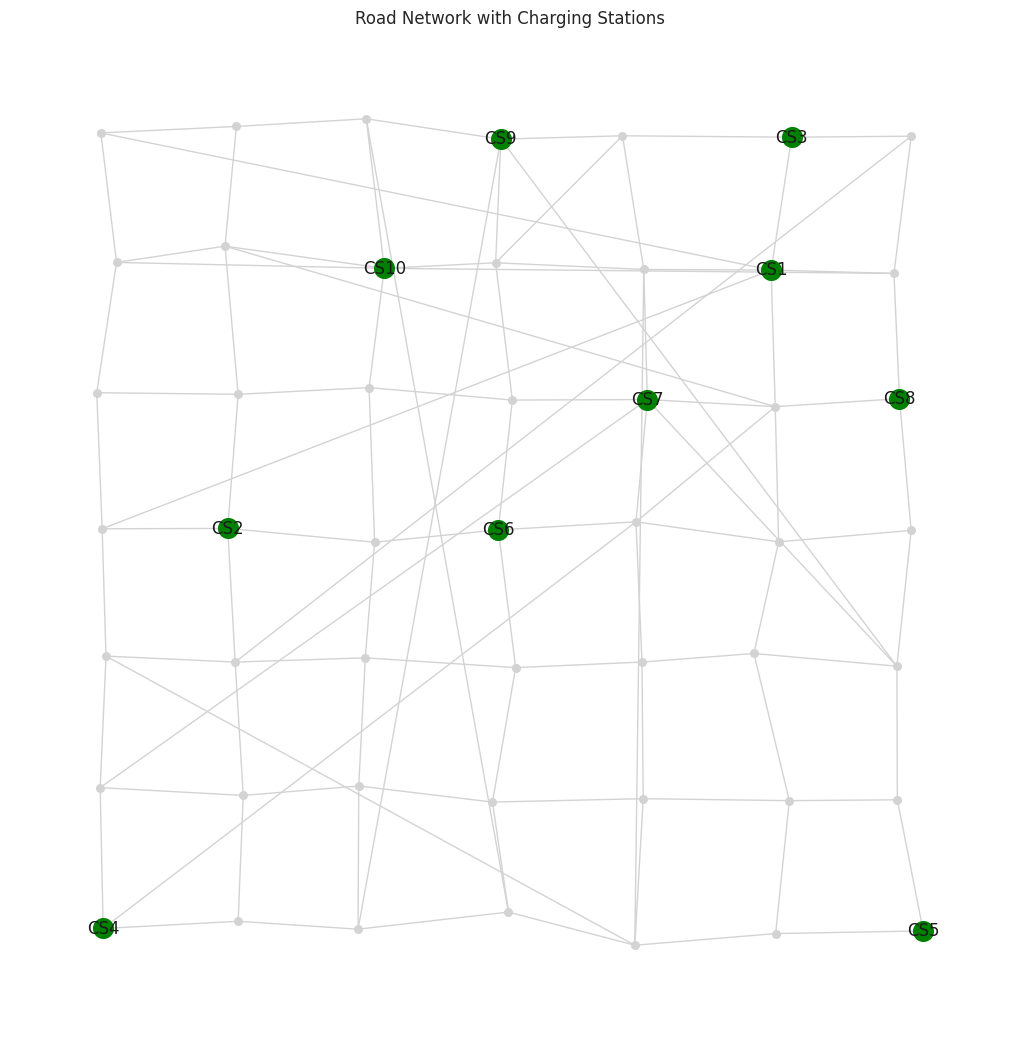

In [25]:
def generate_ev_fleet(num_vehicles=100, network=None):
    """
    Generate a fleet of electric vehicles with varying characteristics.

    Parameters:
        num_vehicles (int): Number of EVs to generate
        network (nx.Graph): Road network for initial positioning

    Returns:
        pd.DataFrame: DataFrame containing EV characteristics
    """
    ev_data = {
        'vehicle_id': list(range(1, num_vehicles + 1)),
        'battery_capacity': np.random.uniform(30, 60, num_vehicles),  # kWh
        'energy_consumption': np.random.uniform(0.15, 0.25, num_vehicles),  # kWh/km
        'initial_soc': np.random.uniform(0.2, 0.8, num_vehicles),  # Percentage of battery
        'max_range': [],  # Will be calculated
        'current_position': []  # Node ID in the network
    }

    # Calculate max range based on battery capacity and energy consumption
    for i in range(num_vehicles):
        max_range = ev_data['battery_capacity'][i] / ev_data['energy_consumption'][i]
        ev_data['max_range'].append(max_range)

        # Assign a random node in the network as current position
        if network:
            ev_data['current_position'].append(random.choice(list(network.nodes())))
        else:
            ev_data['current_position'].append(None)

    # Create DataFrame
    ev_fleet = pd.DataFrame(ev_data)

    # Add more vehicle-specific parameters from the existing VEHICLE_PARAMETERS
    for vehicle_id in ev_fleet['vehicle_id']:
        # Slightly vary the parameters for each vehicle
        variation = np.random.uniform(0.9, 1.1)
        ev_fleet.loc[ev_fleet['vehicle_id'] == vehicle_id, 'mass'] = VEHICLE_PARAMETERS['mass'] * variation
        ev_fleet.loc[ev_fleet['vehicle_id'] == vehicle_id, 'wheel_radius'] = VEHICLE_PARAMETERS['wheel_radius'] * variation
        ev_fleet.loc[ev_fleet['vehicle_id'] == vehicle_id, 'drive_efficiency'] = min(1.0, VEHICLE_PARAMETERS['drive_efficiency'] * variation)

    return ev_fleet

def generate_charging_stations(num_stations=10, network=None):
    """
    Generate charging stations across the road network.

    Parameters:
        num_stations (int): Number of charging stations to generate
        network (nx.Graph): Road network for positioning

    Returns:
        pd.DataFrame: DataFrame containing charging station information
    """
    if not network:
        return None

    station_nodes = random.sample(list(network.nodes()), num_stations)

    charging_station_data = {
        'station_id': list(range(1, num_stations + 1)),
        'node_id': station_nodes,
        'capacity': np.random.randint(5, 16, num_stations),  # Number of charging spots
        'power_rating': np.random.choice([50, 100, 150, 250], num_stations),  # kW
        'current_availability': [],  # Will be calculated
        'position': []  # Geographic coordinates
    }

    pos = nx.get_node_attributes(network, 'pos')
    for i, node in enumerate(station_nodes):
        charging_station_data['current_availability'].append(charging_station_data['capacity'][i])
        charging_station_data['position'].append(pos[node])

    charging_stations = pd.DataFrame(charging_station_data)
    return charging_stations

# Generate the EV fleet
ev_fleet = generate_ev_fleet(100, city_network)

# Generate charging stations
charging_stations = generate_charging_stations(10, city_network)

# Display EV fleet statistics
print(f"Electric Vehicle Fleet Statistics:")
print(f"Number of vehicles: {len(ev_fleet)}")
print(f"Average battery capacity: {ev_fleet['battery_capacity'].mean():.2f} kWh")
print(f"Average energy consumption: {ev_fleet['energy_consumption'].mean():.4f} kWh/km")
print(f"Average initial SoC: {(ev_fleet['initial_soc'].mean() * 100):.1f}%")
print(f"Average max range: {ev_fleet['max_range'].mean():.2f} km")

# Display charging station information
print("\nCharging Station Statistics:")
print(f"Number of stations: {len(charging_stations)}")
print(f"Total charging capacity: {charging_stations['capacity'].sum()} vehicles")
print(f"Average power rating: {charging_stations['power_rating'].mean():.2f} kW")

# Plot the road network with charging stations
plt.figure(figsize=(10, 10))
pos = nx.get_node_attributes(city_network, 'pos')
nx.draw(city_network, pos, with_labels=False, node_size=30, node_color='lightgray', edge_color='lightgray')

# Highlight charging station nodes
station_nodes = charging_stations['node_id'].tolist()
nx.draw_networkx_nodes(city_network, pos, nodelist=station_nodes, node_color='green', node_size=200)

# Add labels for charging stations
station_labels = {node: f"CS{i+1}" for i, node in enumerate(station_nodes)}
nx.draw_networkx_labels(city_network, pos, labels=station_labels)

plt.title("Road Network with Charging Stations")
plt.show()

In [59]:
!pip install colorama


📊 Electric Vehicle Fleet Statistics

╒════════════════════════════╤═══════════════╕
│ Number of vehicles         │           100 │
├────────────────────────────┼───────────────┤
│ Average battery capacity   │     46.38 kWh │
├────────────────────────────┼───────────────┤
│ Average energy consumption │ 0.1975 kWh/km │
├────────────────────────────┼───────────────┤
│ Average initial SoC        │         48.1% │
├────────────────────────────┼───────────────┤
│ Average max range          │     240.67 km │
╘════════════════════════════╧═══════════════╛

📊 Charging Station Statistics

╒═════════════════════════╤═════════════╕
│ Number of stations      │          10 │
├─────────────────────────┼─────────────┤
│ Total charging capacity │ 93 vehicles │
├─────────────────────────┼─────────────┤
│ Average power rating    │   180.00 kW │
╘═════════════════════════╧═════════════╛


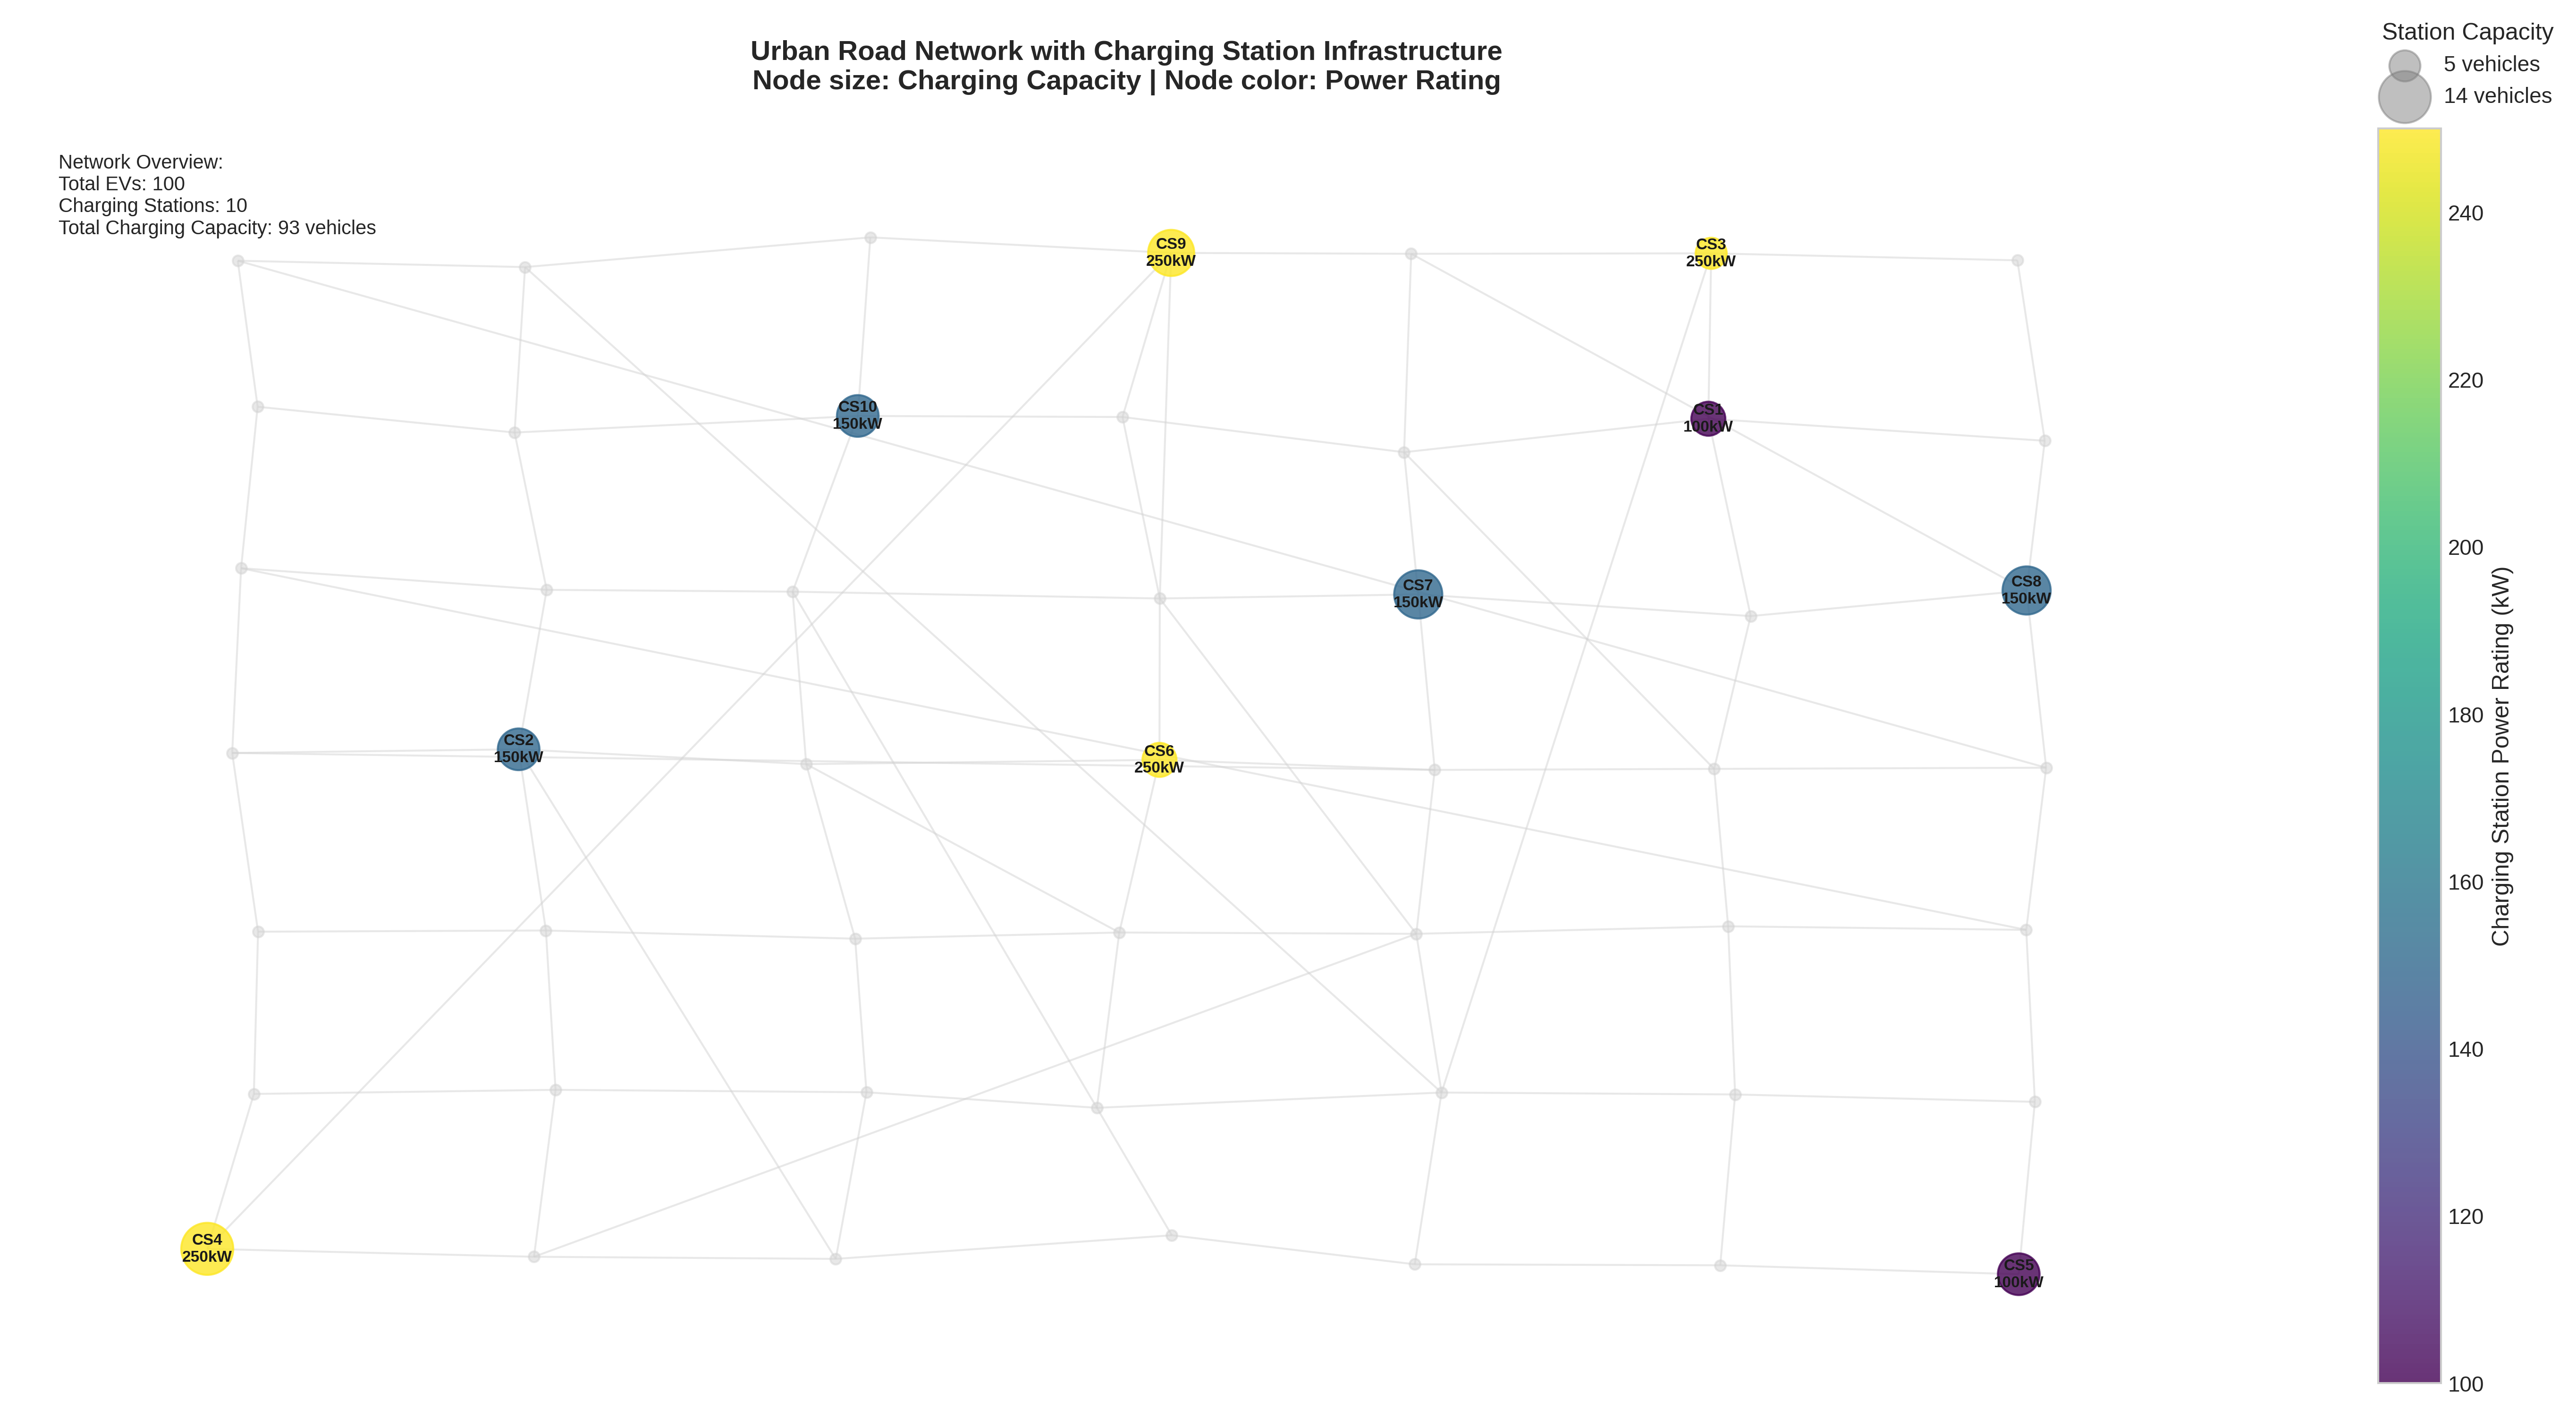

In [64]:
import matplotlib.pyplot as plt
import networkx as nx
import seaborn as sns
from colorama import Fore, Style, init

# Initialize colorama
init()

# Create a styled statistics display function
def print_statistics_block(title, stats_dict):
    print(f"\n{Fore.CYAN}{'='*60}")
    print(f"{Fore.WHITE}📊 {title}")
    print(f"{Fore.CYAN}{'='*60}{Style.RESET_ALL}\n")

    data = [[k, v] for k, v in stats_dict.items()]
    print(tabulate(data,
                  tablefmt="fancy_grid",
                  colalign=("left", "right")))

# EV Fleet Statistics
ev_stats = {
    "Number of vehicles": f"{len(ev_fleet)}",
    "Average battery capacity": f"{ev_fleet['battery_capacity'].mean():.2f} kWh",
    "Average energy consumption": f"{ev_fleet['energy_consumption'].mean():.4f} kWh/km",
    "Average initial SoC": f"{(ev_fleet['initial_soc'].mean() * 100):.1f}%",
    "Average max range": f"{ev_fleet['max_range'].mean():.2f} km"
}

# Charging Station Statistics
cs_stats = {
    "Number of stations": f"{len(charging_stations)}",
    "Total charging capacity": f"{charging_stations['capacity'].sum()} vehicles",
    "Average power rating": f"{charging_stations['power_rating'].mean():.2f} kW"
}

# Print statistics
print_statistics_block("Electric Vehicle Fleet Statistics", ev_stats)
print_statistics_block("Charging Station Statistics", cs_stats)

# Create enhanced visualization
plt.figure(figsize=(20, 10), dpi=300)
# plt.style.use('whitegrid')

# Get node positions
pos = nx.get_node_attributes(city_network, 'pos')

# Draw base network
nx.draw_networkx_edges(city_network, pos,
                      edge_color='lightgray',
                      alpha=0.5,
                      width=1)

# Draw regular nodes
regular_nodes = list(set(city_network.nodes()) - set(charging_stations['node_id']))
nx.draw_networkx_nodes(city_network, pos,
                      nodelist=regular_nodes,
                      node_size=30,
                      node_color='lightgray',
                      alpha=0.5)

# Draw charging stations with a more sophisticated style
station_nodes = charging_stations['node_id'].tolist()
station_sizes = charging_stations['capacity'] * 50  # Scale node size by capacity
station_colors = charging_stations['power_rating']  # Color by power rating

nodes = nx.draw_networkx_nodes(city_network, pos,
                             nodelist=station_nodes,
                             node_size=station_sizes,
                             node_color=station_colors,
                             cmap=plt.cm.viridis,
                             alpha=0.8)

# Add colorbar
plt.colorbar(nodes, label='Charging Station Power Rating (kW)')

# Add labels for charging stations
station_labels = {node: f"CS{i+1}\n{charging_stations['power_rating'].iloc[i]:.0f}kW"
                 for i, node in enumerate(station_nodes)}
nx.draw_networkx_labels(city_network, pos,
                       labels=station_labels,
                       font_size=8,
                       font_weight='bold')

# Enhance the plot with titles and labels
plt.title("Urban Road Network with Charging Station Infrastructure\n" +
          "Node size: Charging Capacity | Node color: Power Rating",
          fontsize=14, pad=20, fontweight='bold')

# Add legend for node sizes
sizes = [min(station_sizes), max(station_sizes)]
labels = [f"{min(charging_stations['capacity'])} vehicles",
          f"{max(charging_stations['capacity'])} vehicles"]
legend_elements = [plt.scatter([], [], s=s, c='gray', alpha=0.5, label=l)
                  for s, l in zip(sizes, labels)]
plt.legend(handles=legend_elements, title="Station Capacity",
          loc='upper right', bbox_to_anchor=(1.15, 1.1))

# Remove axes
plt.axis('off')

# Add network statistics as text
stats_text = (f"Network Overview:\n"
              f"Total EVs: {len(ev_fleet)}\n"
              f"Charging Stations: {len(charging_stations)}\n"
              f"Total Charging Capacity: {charging_stations['capacity'].sum()} vehicles")
plt.text(0.02, 0.98, stats_text,
         transform=plt.gca().transAxes,
         bbox=dict(facecolor='white', alpha=0.8, edgecolor='none'),
         fontsize=10,
         verticalalignment='top')

# Adjust layout and display
plt.tight_layout()
plt.show()

## Renewable Energy and Grid Data

Renewable Energy Statistics:
Data time range: 2025-03-08 00:00:00 to 2025-03-14 23:00:00
Average solar energy: 1.58 kW
Average wind energy: 1.49 kW
Average grid price: $0.1396 per kWh
Average V2G incentive price: $0.1438 per kWh


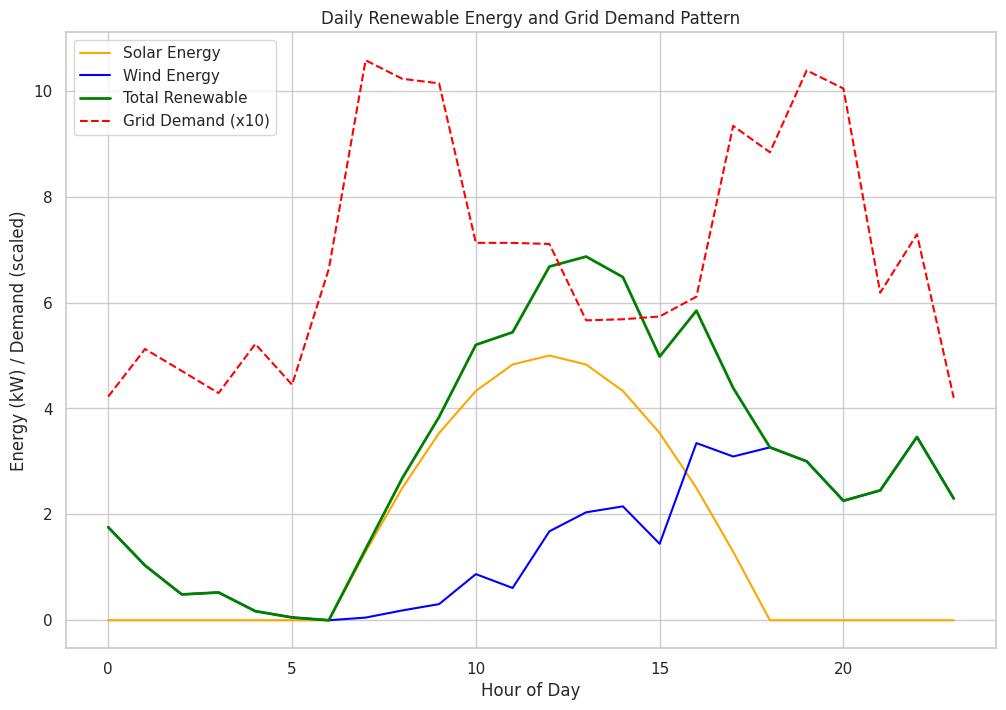

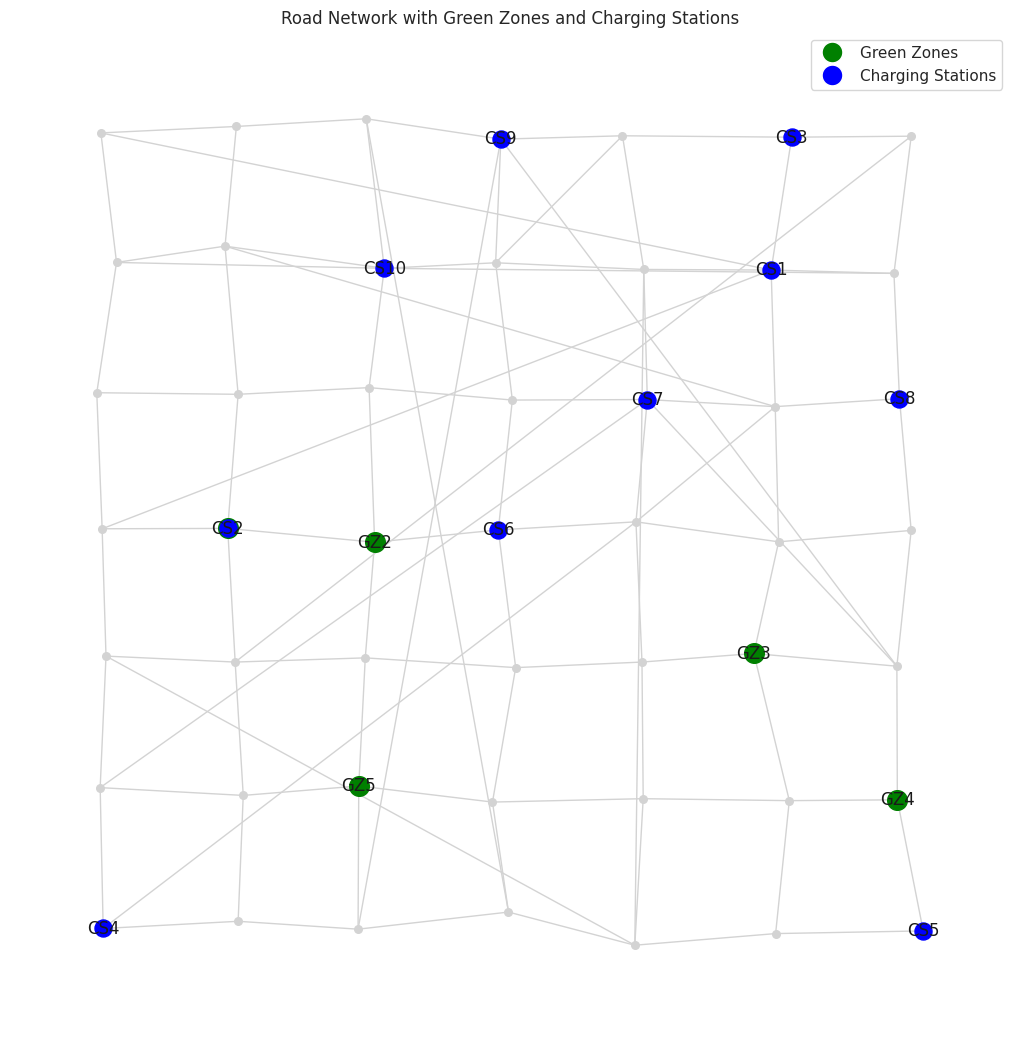

In [26]:
def generate_renewable_energy_data(days=7, time_step_minutes=60):
    """
    Generate renewable energy availability data.

    Parameters:
        days (int): Number of days to simulate
        time_step_minutes (int): Time resolution in minutes

    Returns:
        pd.DataFrame: DataFrame containing renewable energy data
    """
    # Calculate number of time steps
    total_minutes = days * 24 * 60
    num_steps = total_minutes // time_step_minutes

    # Create time index
    start_time = datetime.now().replace(hour=0, minute=0, second=0, microsecond=0)
    time_index = [start_time + timedelta(minutes=i*time_step_minutes) for i in range(num_steps)]

    # Calculate hour of day for each time step (0-23)
    hours = [(t.hour + t.minute/60) for t in time_index]

    # Generate solar energy availability (peak at noon)
    solar_energy = []
    for hour in hours:
        if 6 <= hour <= 18:  # Daylight hours
            # Sinusoidal pattern peaking at noon
            solar_value = 5 * np.sin(np.pi * (hour - 6) / 12)
            solar_energy.append(max(0, solar_value))
        else:
            solar_energy.append(0)  # No solar at night

    # Generate wind energy with more randomness (peak in evening)
    wind_energy = []
    for hour in hours:
        # Base pattern with evening peak
        base_wind = 1.5 + 1.5 * np.sin(np.pi * (hour - 12) / 12)
        # Add randomness
        random_factor = np.random.normal(1, 0.3)
        wind_value = max(0, base_wind * random_factor)
        wind_energy.append(wind_value)

    # Calculate grid demand and price
    grid_demand = []
    grid_price = []

    for hour in hours:
        # Morning peak (7-9am) and evening peak (5-8pm)
        if (7 <= hour <= 9) or (17 <= hour <= 20):
            base_demand = np.random.uniform(0.8, 1.0)  # High demand
            price = np.random.uniform(0.15, 0.25)  # Higher price
        elif 23 <= hour or hour <= 5:  # Night (11pm-5am)
            base_demand = np.random.uniform(0.3, 0.5)  # Low demand
            price = np.random.uniform(0.05, 0.08)  # Lower price
        else:  # Rest of day
            base_demand = np.random.uniform(0.5, 0.7)  # Medium demand
            price = np.random.uniform(0.10, 0.15)  # Medium price

        # Add some day-to-day variation
        day_factor = 1 + 0.1 * np.sin(2 * np.pi * (time_index[hours.index(hour)].day % 7) / 7)
        grid_demand.append(base_demand * day_factor)
        grid_price.append(price * day_factor)

    # Generate V2G incentives based on grid demand
    v2g_price = [price * 1.2 if demand > 0.7 else price * 0.8 for price, demand in zip(grid_price, grid_demand)]

    # Create DataFrame
    data = {
        'time': time_index,
        'solar_energy_kW': solar_energy,
        'wind_energy_kW': wind_energy,
        'total_renewable_kW': [s + w for s, w in zip(solar_energy, wind_energy)],
        'grid_demand': grid_demand,  # normalized between 0 and 1
        'grid_price_USD_per_kWh': grid_price,
        'v2g_price_USD_per_kWh': v2g_price
    }

    renewable_data = pd.DataFrame(data)
    return renewable_data

def define_green_zones(network, renewable_data, num_green_zones=5):
    """
    Define green zones in the network based on renewable energy availability.

    Parameters:
        network (nx.Graph): Road network
        renewable_data (pd.DataFrame): Renewable energy data
        num_green_zones (int): Number of green zones to define

    Returns:
        list: List of node IDs that are green zones
    """
    # Select nodes with high potential for renewable energy (simplified approach)
    green_zone_nodes = random.sample(list(network.nodes()), num_green_zones)

    # Set attribute in network
    for node in network.nodes():
        if node in green_zone_nodes:
            network.nodes[node]['is_green_zone'] = True
        else:
            network.nodes[node]['is_green_zone'] = False

    return green_zone_nodes

# Generate renewable energy data for a week with hourly resolution
renewable_energy_data = generate_renewable_energy_data(7, 60)

# Define green zones in the network
green_zones = define_green_zones(city_network, renewable_energy_data, 5)

# Display renewable energy statistics
print("Renewable Energy Statistics:")
print(f"Data time range: {renewable_energy_data['time'].min()} to {renewable_energy_data['time'].max()}")
print(f"Average solar energy: {renewable_energy_data['solar_energy_kW'].mean():.2f} kW")
print(f"Average wind energy: {renewable_energy_data['wind_energy_kW'].mean():.2f} kW")
print(f"Average grid price: ${renewable_energy_data['grid_price_USD_per_kWh'].mean():.4f} per kWh")
print(f"Average V2G incentive price: ${renewable_energy_data['v2g_price_USD_per_kWh'].mean():.4f} per kWh")

# Plot renewable energy over time
plt.figure(figsize=(12, 8))

# Create a 24-hour sample for plotting
sample_data = renewable_energy_data.iloc[:24]
hours = range(24)

plt.plot(hours, sample_data['solar_energy_kW'], label='Solar Energy', color='orange')
plt.plot(hours, sample_data['wind_energy_kW'], label='Wind Energy', color='blue')
plt.plot(hours, sample_data['total_renewable_kW'], label='Total Renewable', color='green', linewidth=2)
plt.plot(hours, sample_data['grid_demand'] * 10, label='Grid Demand (x10)', color='red', linestyle='--')

plt.xlabel('Hour of Day')
plt.ylabel('Energy (kW) / Demand (scaled)')
plt.title('Daily Renewable Energy and Grid Demand Pattern')
plt.legend()
plt.grid(True)
plt.show()

# Plot the road network with green zones
plt.figure(figsize=(10, 10))
pos = nx.get_node_attributes(city_network, 'pos')

# Draw the base network
nx.draw(city_network, pos, with_labels=False, node_size=30, node_color='lightgray', edge_color='lightgray')

# Highlight green zones
nx.draw_networkx_nodes(city_network, pos, nodelist=green_zones, node_color='green', node_size=200)

# Highlight charging stations in a different color
charging_nodes = charging_stations['node_id'].tolist()
nx.draw_networkx_nodes(city_network, pos, nodelist=charging_nodes, node_color='blue', node_size=150)

# Add labels
green_zone_labels = {node: f"GZ{i+1}" for i, node in enumerate(green_zones)}
station_labels = {node: f"CS{i+1}" for i, node in enumerate(charging_nodes)}
labels = {**green_zone_labels, **station_labels}
nx.draw_networkx_labels(city_network, pos, labels=labels)

plt.title("Road Network with Green Zones and Charging Stations")
plt.legend([plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='green', markersize=15),
            plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', markersize=15)],
           ['Green Zones', 'Charging Stations'])
plt.show()


⚡ Renewable Energy System Statistics

╒═══════════════════════╤════════════════════════════════════════════╕
│ Metric                │                                      Value │
╞═══════════════════════╪════════════════════════════════════════════╡
│ Time Range            │ 2025-03-08 00:00:00 to 2025-03-14 23:00:00 │
├───────────────────────┼────────────────────────────────────────────┤
│ Average Solar Energy  │                                    1.58 kW │
├───────────────────────┼────────────────────────────────────────────┤
│ Average Wind Energy   │                                    1.49 kW │
├───────────────────────┼────────────────────────────────────────────┤
│ Average Grid Price    │                            $0.1396 per kWh │
├───────────────────────┼────────────────────────────────────────────┤
│ Average V2G Incentive │                            $0.1438 per kWh │
╘═══════════════════════╧════════════════════════════════════════════╛


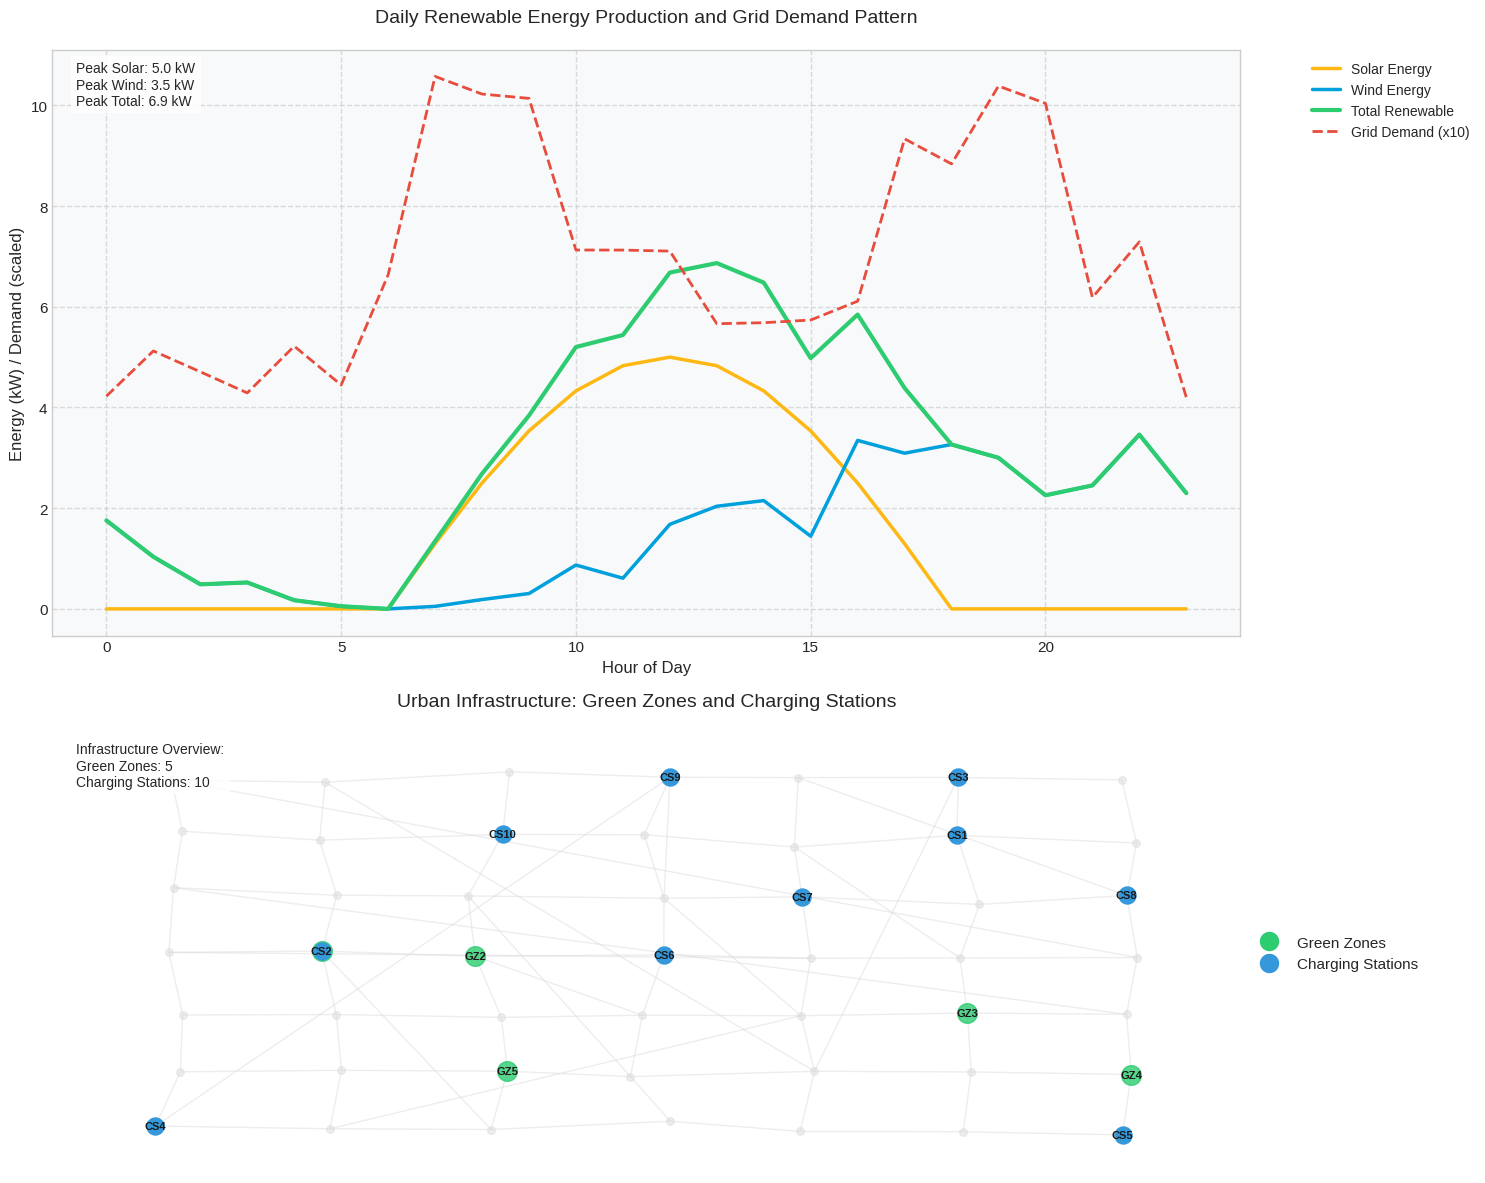

In [65]:
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
from tabulate import tabulate
from colorama import Fore, Style, init
import matplotlib.dates as mdates

# Initialize colorama
init()

# Function to display statistics in a formatted table
def print_energy_statistics(data):
    print(f"\n{Fore.CYAN}{'='*60}")
    print(f"{Fore.WHITE}⚡ Renewable Energy System Statistics")
    print(f"{Fore.CYAN}{'='*60}{Style.RESET_ALL}\n")

    stats = [
        ["Time Range", f"{data['time'].min()} to {data['time'].max()}"],
        ["Average Solar Energy", f"{data['solar_energy_kW'].mean():.2f} kW"],
        ["Average Wind Energy", f"{data['wind_energy_kW'].mean():.2f} kW"],
        ["Average Grid Price", f"${data['grid_price_USD_per_kWh'].mean():.4f} per kWh"],
        ["Average V2G Incentive", f"${data['v2g_price_USD_per_kWh'].mean():.4f} per kWh"]
    ]

    print(tabulate(stats,
                  headers=["Metric", "Value"],
                  tablefmt="fancy_grid",
                  colalign=("left", "right")))

# Display statistics
print_energy_statistics(renewable_energy_data)

# Create figure with subplots
fig = plt.figure(figsize=(15, 12))
gs = plt.GridSpec(2, 1, height_ratios=[2, 1.5])

# Plot 1: Energy Production and Demand
ax1 = fig.add_subplot(gs[0])
sample_data = renewable_energy_data.iloc[:24]
hours = range(24)

# Plot with enhanced styling
ax1.plot(hours, sample_data['solar_energy_kW'],
         label='Solar Energy', color='#FDB813', linewidth=2.5)
ax1.plot(hours, sample_data['wind_energy_kW'],
         label='Wind Energy', color='#00A0DC', linewidth=2.5)
ax1.plot(hours, sample_data['total_renewable_kW'],
         label='Total Renewable', color='#2ECC71', linewidth=3)
ax1.plot(hours, sample_data['grid_demand'] * 10,
         label='Grid Demand (x10)', color='#E74C3C',
         linestyle='--', linewidth=2)

# Enhance grid and styling
ax1.grid(True, linestyle='--', alpha=0.7)
ax1.set_xlabel('Hour of Day', fontsize=12)
ax1.set_ylabel('Energy (kW) / Demand (scaled)', fontsize=12)
ax1.set_title('Daily Renewable Energy Production and Grid Demand Pattern',
              fontsize=14, pad=20)
ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)
ax1.set_facecolor('#f8f9fa')

# Add summary statistics
stats_text = (f"Peak Solar: {sample_data['solar_energy_kW'].max():.1f} kW\n"
              f"Peak Wind: {sample_data['wind_energy_kW'].max():.1f} kW\n"
              f"Peak Total: {sample_data['total_renewable_kW'].max():.1f} kW")
ax1.text(0.02, 0.98, stats_text,
         transform=ax1.transAxes,
         bbox=dict(facecolor='white', alpha=0.8, edgecolor='none'),
         fontsize=10,
         verticalalignment='top')

# Plot 2: Network with Green Zones and Charging Stations
ax2 = fig.add_subplot(gs[1])
pos = nx.get_node_attributes(city_network, 'pos')

# Draw base network with enhanced styling
nx.draw_networkx_edges(city_network, pos,
                      edge_color='#dcdcdc',
                      alpha=0.5,
                      width=1,
                      ax=ax2)

# Draw regular nodes
regular_nodes = list(set(city_network.nodes()) - set(green_zones) - set(charging_stations['node_id']))
nx.draw_networkx_nodes(city_network, pos,
                      nodelist=regular_nodes,
                      node_size=30,
                      node_color='#dcdcdc',
                      alpha=0.5,
                      ax=ax2)

# Draw green zones with gradient color
nx.draw_networkx_nodes(city_network, pos,
                      nodelist=green_zones,
                      node_color='#2ECC71',
                      node_size=200,
                      alpha=0.8,
                      ax=ax2)

# Draw charging stations
charging_nodes = charging_stations['node_id'].tolist()
nx.draw_networkx_nodes(city_network, pos,
                      nodelist=charging_nodes,
                      node_color='#3498DB',
                      node_size=150,
                      ax=ax2)

# Add labels with better formatting
green_zone_labels = {node: f"GZ{i+1}" for i, node in enumerate(green_zones)}
station_labels = {node: f"CS{i+1}" for i, node in enumerate(charging_nodes)}
labels = {**green_zone_labels, **station_labels}
nx.draw_networkx_labels(city_network, pos,
                       labels=labels,
                       font_size=8,
                       font_weight='bold',
                       ax=ax2)

# Add legend
legend_elements = [plt.Line2D([0], [0], marker='o', color='w',
                             markerfacecolor='#2ECC71', markersize=15, label='Green Zones'),
                  plt.Line2D([0], [0], marker='o', color='w',
                             markerfacecolor='#3498DB', markersize=15, label='Charging Stations')]
ax2.legend(handles=legend_elements,
          loc='center left',
          bbox_to_anchor=(1, 0.5))

ax2.set_title('Urban Infrastructure: Green Zones and Charging Stations',
              fontsize=14, pad=20)
ax2.axis('off')

# Add network statistics
network_stats = (f"Infrastructure Overview:\n"
                f"Green Zones: {len(green_zones)}\n"
                f"Charging Stations: {len(charging_stations)}")
ax2.text(0.02, 0.98, network_stats,
         transform=ax2.transAxes,
         bbox=dict(facecolor='white', alpha=0.8, edgecolor='none'),
         fontsize=10,
         verticalalignment='top')

# Adjust layout and display
plt.tight_layout()
plt.show()

## Evaluation Metrics

In [34]:
def calculate_energy_consumption(route, network, vehicle_params):
    """
    Calculate energy consumption for a given route.

    Parameters:
        route (list): List of node IDs representing the route
        network (nx.Graph): Road network
        vehicle_params (dict): Vehicle parameters

    Returns:
        float: Energy consumption in kWh
    """
    # Use the compute_energy_consumption function from the existing implementation
    route_sections = []

    for i in range(len(route) - 1):
        u, v = route[i], route[i + 1]

        if (u, v) in network.edges():
            edge_data = network[u][v]
            section = {
                "summary": {
                    "length": edge_data['length'],
                    "duration": edge_data['travel_time']
                },
                "grade": edge_data.get('grade', 0),
                "acceleration": 0  # Assume constant speed
            }
            route_sections.append(section)

    energy_consumption = compute_energy_consumption(route_sections, vehicle_params)
    return sum(energy_consumption) / 3_600_000  # Convert from J to kWh

def calculate_v2g_incentives(route, network, renewable_data, current_time=None):
    """
    Calculate V2G incentives for a given route.

    Parameters:
        route (list): List of node IDs representing the route
        network (nx.Graph): Road network
        renewable_data (pd.DataFrame): Renewable energy data
        current_time (datetime): Current simulation time

    Returns:
        float: V2G incentives in USD
    """
    if current_time is None:
        current_time = datetime.now()

    # Find the closest time in renewable_data
    time_diff = [(t - current_time).total_seconds() for t in renewable_data['time']]
    closest_idx = time_diff.index(min([abs(td) for td in time_diff]))

    # Get V2G price at the current time
    v2g_price = renewable_data.iloc[closest_idx]['v2g_price_USD_per_kWh']

    # Estimate potential V2G discharge capacity (simplified)
    # Assume 10% of battery capacity is available for V2G if we pass through a green zone
    v2g_energy = 0
    for node in route:
        if network.nodes[node].get('is_green_zone', False):
            # For simplicity, assume 2 kWh is available for grid support at each green zone
            v2g_energy += 2

    # Calculate incentive
    v2g_incentive = v2g_price * v2g_energy

    return v2g_incentive

def calculate_travel_time(route, network):
    """
    Calculate the total travel time for a route.

    Parameters:
        route (list): List of node IDs representing the route
        network (nx.Graph): Road network

    Returns:
        float: Travel time in minutes
    """
    total_time = 0
    for i in range(len(route) - 1):
        u, v = route[i], route[i + 1]
        if (u, v) in network.edges():
            total_time += network[u][v]['travel_time']

    return total_time / 60  # Convert from seconds to minutes

def calculate_green_zone_compliance(route, network):
    """
    Calculate the percentage of the route that passes through GreenZones.

    Parameters:
        route (list): List of node IDs representing the route
        network (nx.Graph): Road network

    Returns:
        float: Percentage of route through GreenZones
    """
    green_zone_nodes = [node for node in network.nodes() if network.nodes[node].get('is_green_zone', False)]

    # Count green zone nodes in route
    green_nodes_in_route = sum(1 for node in route if node in green_zone_nodes)

    # Calculate percentage
    if len(route) > 0:
        return (green_nodes_in_route / len(route)) * 100
    else:
        return 0

def calculate_emissions_reduction(route, network, vehicle_params, baseline_emissions=0.2):
    """
    Calculate the reduction in carbon emissions.

    Parameters:
        route (list): List of node IDs representing the route
        network (nx.Graph): Road network
        vehicle_params (dict): Vehicle parameters
        baseline_emissions (float): Baseline emissions in kg CO2/km for conventional vehicles

    Returns:
        float: Emissions reduction in kg CO2
    """
    # Calculate total route length
    total_length = 0
    for i in range(len(route) - 1):
        u, v = route[i], route[i + 1]
        if (u, v) in network.edges():
            total_length += network[u][v]['length']

    # Convert to kilometers
    total_length_km = total_length / 1000

    # Calculate baseline emissions (conventional vehicle)
    conventional_emissions = total_length_km * baseline_emissions

    # Calculate EV emissions based on energy mix
    # Simplified approach: assume 0.1 kg CO2/kWh for electricity
    ev_energy = calculate_energy_consumption(route, network, vehicle_params)
    ev_emissions = ev_energy * 0.1

    # Calculate reduction
    emissions_reduction = conventional_emissions - ev_emissions

    return emissions_reduction

def calculate_route_cost(route, network, vehicle_params, renewable_data, current_time=None):
    """
    Calculate the total cost of a route including energy, incentives, and penalties.

    Parameters:
        route (list): List of node IDs representing the route
        network (nx.Graph): Road network
        vehicle_params (dict): Vehicle parameters
        renewable_data (pd.DataFrame): Renewable energy data
        current_time (datetime): Current simulation time

    Returns:
        float: Total cost in USD
    """
    if current_time is None:
        current_time = datetime.now()

    # Find the closest time in renewable_data
    time_diff = [(t - current_time).total_seconds() for t in renewable_data['time']]
    closest_idx = time_diff.index(min([abs(td) for td in time_diff]))

    # Get energy price at the current time
    energy_price = renewable_data.iloc[closest_idx]['grid_price_USD_per_kWh']

    # Calculate energy consumption cost
    energy_consumption = calculate_energy_consumption(route, network, vehicle_params)
    energy_cost = energy_consumption * energy_price

    # Calculate V2G incentives (negative cost)
    v2g_incentives = calculate_v2g_incentives(route, network, renewable_data, current_time)

    # Green zone penalties (if any) - simplified approach
    green_zone_compliance = calculate_green_zone_compliance(route, network)
    green_zone_penalty = 0
    if green_zone_compliance < 10:  # Arbitrary threshold
        green_zone_penalty = 1.0  # $1 penalty for low green zone compliance

    # Total cost
    total_cost = energy_cost - v2g_incentives + green_zone_penalty

    return total_cost

def evaluate_routing_strategy(origin, destination, network, vehicle_params, renewable_data,
                             strategy='fastest', current_time=None):
    """
    Evaluate a routing strategy using multiple metrics.

    Parameters:
        origin (int): Origin node ID
        destination (int): Destination node ID
        network (nx.Graph): Road network
        vehicle_params (dict): Vehicle parameters
        renewable_data (pd.DataFrame): Renewable energy data
        strategy (str): Routing strategy ('fastest', 'shortest', 'energy')
        current_time (datetime): Current simulation time

    Returns:
        dict: Dictionary of evaluation metrics
    """
    # Get route based on strategy
    if strategy == 'fastest':
        route = nx.shortest_path(network, origin, destination, weight='travel_time')
    elif strategy == 'shortest':
        route = nx.shortest_path(network, origin, destination, weight='length')
    elif strategy == 'energy':
        # Create energy-weighted graph
        energy_weights = {}
        for u, v in network.edges():
            # Estimate energy for this edge
            edge_data = network[u][v]
            section = {
                "summary": {
                    "length": edge_data['length'],
                    "duration": edge_data['travel_time']
                },
                "grade": edge_data.get('grade', 0),
                "acceleration": 0
            }
            energy = compute_energy_consumption([section], vehicle_params)[0]
            energy_weights[(u, v)] = energy

        # Create view of the graph with energy weights
        energy_view = nx.DiGraph()
        energy_view.add_nodes_from(network.nodes())
        for u, v in network.edges():
            energy_view.add_edge(u, v, weight=energy_weights[(u, v)])

        # Find route
        route = nx.shortest_path(energy_view, origin, destination, weight='weight')
    else:
        raise ValueError(f"Unknown routing strategy: {strategy}")

    # Calculate metrics
    energy_consumption = calculate_energy_consumption(route, network, vehicle_params)
    v2g_incentives = calculate_v2g_incentives(route, network, renewable_data, current_time)
    travel_time = calculate_travel_time(route, network)
    green_zone_compliance = calculate_green_zone_compliance(route, network)
    emissions_reduction = calculate_emissions_reduction(route, network, vehicle_params)
    route_cost = calculate_route_cost(route, network, vehicle_params, renewable_data, current_time)

    # Return metrics
    metrics = {
        'Strategy': strategy,
        'Route': route,
        'Energy Consumption (kWh)': energy_consumption,
        'V2G Incentives (USD)': v2g_incentives,
        'Travel Time (minutes)': travel_time,
        'GreenZone Compliance (%)': green_zone_compliance,
        'Emissions Reduction (kg CO2)': emissions_reduction,
        'Route Cost (USD)': route_cost
    }

    return metrics

def compare_routing_strategies(origin, destination, network, vehicle_params, renewable_data, current_time=None):
    """
    Compare different routing strategies for the same origin-destination pair.

    Parameters:
        origin (int): Origin node ID
        destination (int): Destination node ID
        network (nx.Graph): Road network
        vehicle_params (dict): Vehicle parameters
        renewable_data (pd.DataFrame): Renewable energy data
        current_time (datetime): Current simulation time

    Returns:
        pd.DataFrame: DataFrame with comparison results
    """
    strategies = ['fastest', 'shortest', 'energy']
    results = []

    for strategy in strategies:
        metrics = evaluate_routing_strategy(
            origin, destination, network, vehicle_params, renewable_data, strategy, current_time
        )
        results.append(metrics)

    # Convert to DataFrame for easier comparison
    comparison_df = pd.DataFrame(results)

    # Drop the actual route column for display purposes
    if 'Route' in comparison_df.columns:
        comparison_df = comparison_df.drop('Route', axis=1)

    return comparison_df

Evaluating routes from node 11 to node 26 at 2025-03-08 12:00:00


,Strategy,Energy Consumption (kWh),V2G Incentives (USD),Travel Time (minutes),GreenZone Compliance (%),Emissions Reduction (kg CO2),Route Cost (USD)
0,fastest,0.564,0.000,6.274,0.000,0.989,1.068
1,shortest,0.284,0.000,6.700,0.000,0.872,1.034
2,energy,0.284,0.000,6.700,0.000,0.872,1.034


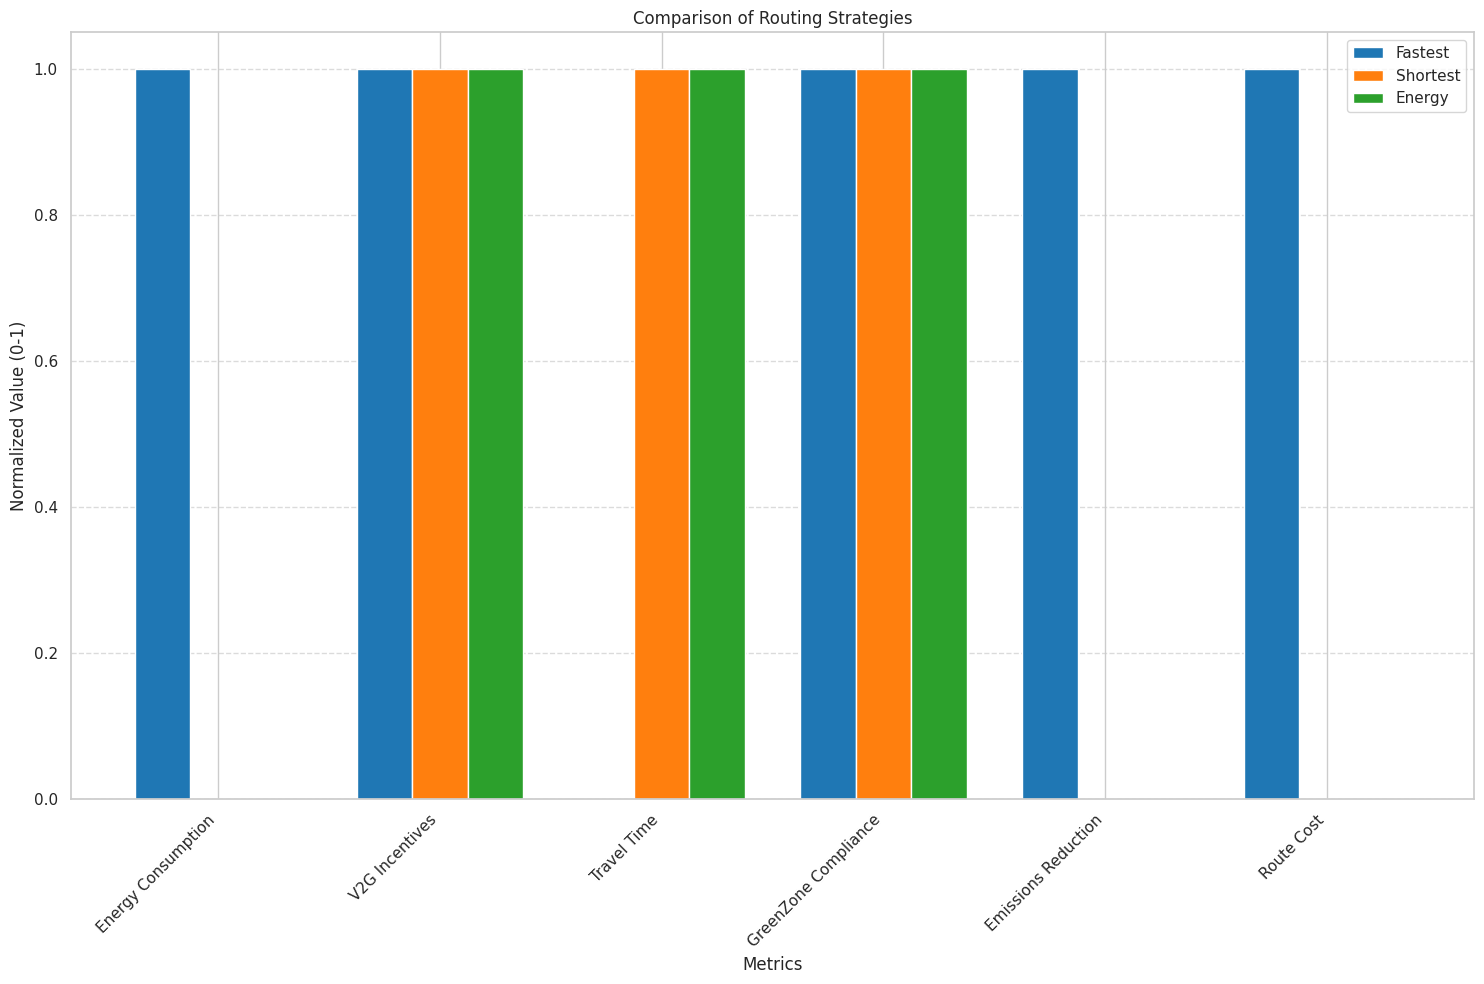

In [38]:
# Set a specific time for evaluation
evaluation_time = renewable_energy_data['time'][12]  # Noon on first day

# Select random origin and destination nodes
origin_node = random.choice(list(city_network.nodes()))
destination_node = random.choice([n for n in city_network.nodes() if n != origin_node])

print(f"Evaluating routes from node {origin_node} to node {destination_node} at {evaluation_time}")

# Compare the three routing strategies
comparison_results = compare_routing_strategies(
    origin_node,
    destination_node,
    city_network,
    VEHICLE_PARAMETERS,
    renewable_energy_data,
    evaluation_time
)

# Display the comparison results
pd.set_option('display.float_format', '{:.3f}'.format)
display(comparison_results)

# Create a bar chart to compare the key metrics
metrics_to_plot = [
    'Energy Consumption (kWh)',
    'V2G Incentives (USD)',
    'Travel Time (minutes)',
    'GreenZone Compliance (%)',
    'Emissions Reduction (kg CO2)',
    'Route Cost (USD)'
]

# Normalize the metrics for better visualization
normalized_data = comparison_results.copy()
for metric in metrics_to_plot:
    max_val = normalized_data[metric].max()
    min_val = normalized_data[metric].min()
    if max_val != min_val:
        normalized_data[metric] = (normalized_data[metric] - min_val) / (max_val - min_val)
    else:
        normalized_data[metric] = 1

# Plot the normalized metrics
plt.figure(figsize=(15, 10))

x = np.arange(len(metrics_to_plot))
width = 0.25

strategies = normalized_data['Strategy'].tolist()
colors = ['#1f77b4', '#ff7f0e', '#2ca02c']  # blue, orange, green

for i, strategy in enumerate(strategies):
    values = [normalized_data.loc[normalized_data['Strategy'] == strategy, metric].values[0] for metric in metrics_to_plot]
    plt.bar(x + (i-1)*width, values, width, label=strategy.capitalize(), color=colors[i])

plt.xlabel('Metrics')
plt.ylabel('Normalized Value (0-1)')
plt.title('Comparison of Routing Strategies')
plt.xticks(x, [m.split(' (')[0] for m in metrics_to_plot], rotation=45, ha='right')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

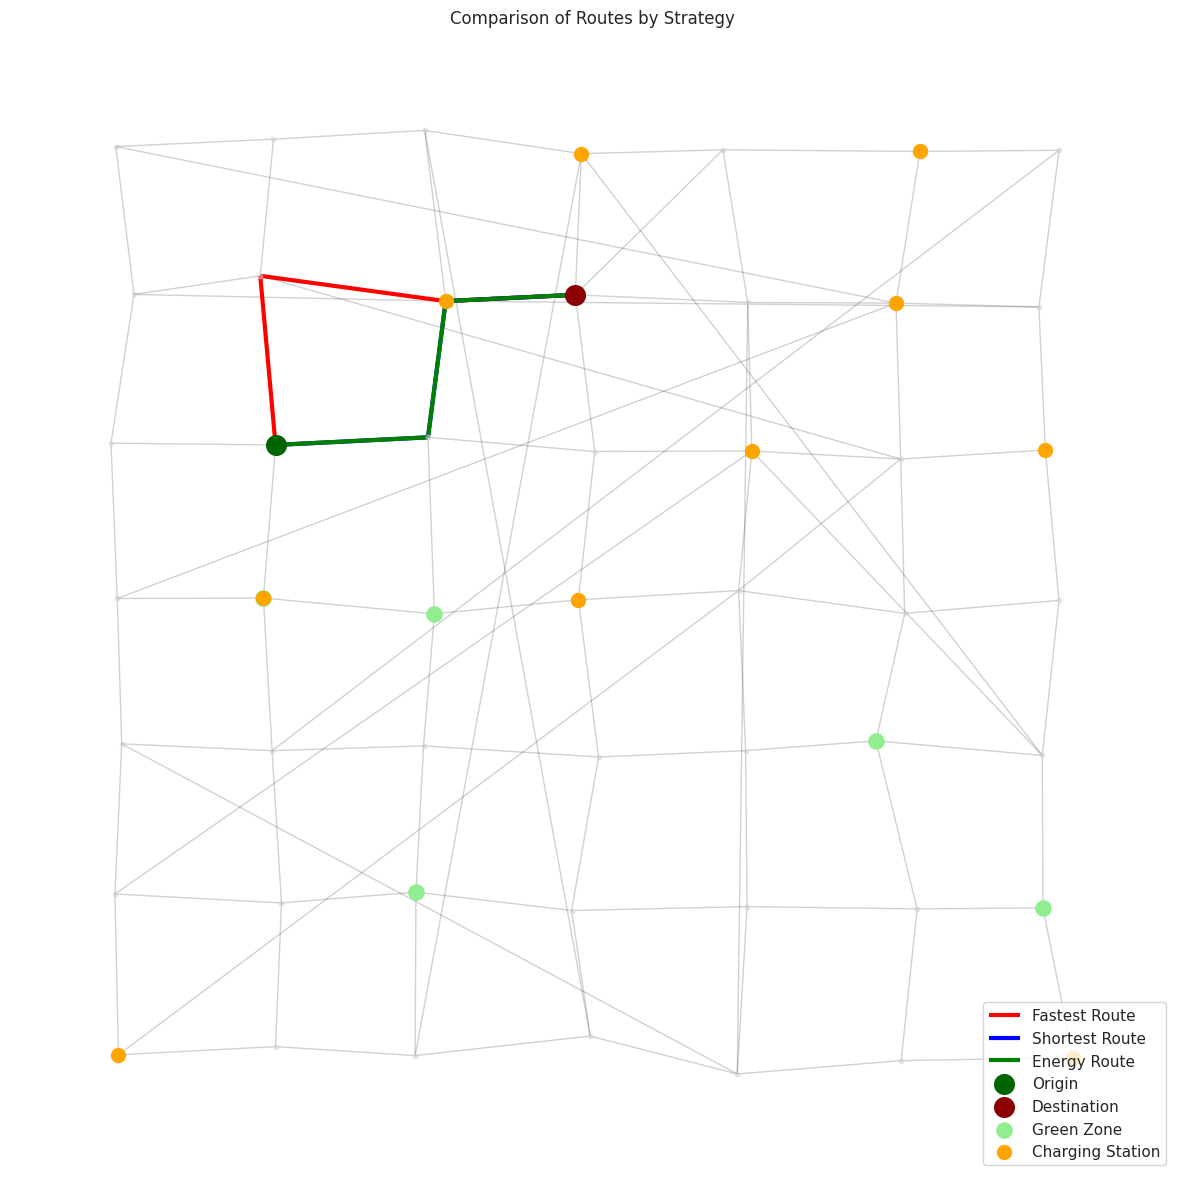

In [40]:
# Generate the paths again for visualization
routes = {}
for strategy in ['fastest', 'shortest', 'energy']:
    metrics = evaluate_routing_strategy(
        origin_node,
        destination_node,
        city_network,
        VEHICLE_PARAMETERS,
        renewable_energy_data,
        strategy=strategy,  # Specify the strategy explicitly
        current_time=evaluation_time
    )
    routes[strategy] = metrics['Route']

# Create a visualization of all three routes on the network
plt.figure(figsize=(12, 12))
pos = nx.get_node_attributes(city_network, 'pos')

# Draw basic network structure
nx.draw_networkx_edges(city_network, pos, alpha=0.2, width=1)
nx.draw_networkx_nodes(city_network, pos, node_size=10, node_color='lightgray', alpha=0.5)

# Draw the routes with different colors
route_colors = {
    'fastest': 'red',
    'shortest': 'blue',
    'energy': 'green'
}

for strategy, route in routes.items():
    # Create edge pairs from route
    route_edges = list(zip(route[:-1], route[1:]))

    # Draw route edges
    nx.draw_networkx_edges(
        city_network, pos,
        edgelist=route_edges,
        edge_color=route_colors[strategy],
        width=3,
        label=f"{strategy.capitalize()} Route"
    )

# Highlight origin and destination
nx.draw_networkx_nodes(
    city_network, pos,
    nodelist=[origin_node],
    node_color='darkgreen',
    node_size=200,
    label='Origin'
)

nx.draw_networkx_nodes(
    city_network, pos,
    nodelist=[destination_node],
    node_color='darkred',
    node_size=200,
    label='Destination'
)

# Add green zones and charging stations
nx.draw_networkx_nodes(
    city_network, pos,
    nodelist=green_zones,
    node_color='lightgreen',
    node_size=120,
    label='Green Zone'
)

charging_nodes = charging_stations['node_id'].tolist()
nx.draw_networkx_nodes(
    city_network, pos,
    nodelist=charging_nodes,
    node_color='orange',
    node_size=100,
    label='Charging Station'
)

plt.title("Comparison of Routes by Strategy")
plt.legend(scatterpoints=1, loc='lower right')
plt.axis('off')
plt.tight_layout()
plt.show()

In [41]:
# Format the results for better display
def format_comparison_results(results_df):
    formatted_df = results_df.copy()

    # Format each column appropriately
    formatted_df['Energy Consumption (kWh)'] = formatted_df['Energy Consumption (kWh)'].map('{:.2f}'.format)
    formatted_df['V2G Incentives (USD)'] = formatted_df['V2G Incentives (USD)'].map('${:.2f}'.format)
    formatted_df['Travel Time (minutes)'] = formatted_df['Travel Time (minutes)'].map('{:.1f}'.format)
    formatted_df['GreenZone Compliance (%)'] = formatted_df['GreenZone Compliance (%)'].map('{:.1f}%'.format)
    formatted_df['Emissions Reduction (kg CO2)'] = formatted_df['Emissions Reduction (kg CO2)'].map('{:.3f}'.format)
    formatted_df['Route Cost (USD)'] = formatted_df['Route Cost (USD)'].map('${:.2f}'.format)

    return formatted_df

# Display the formatted results
formatted_comparison = format_comparison_results(comparison_results)
print("\nDetailed Comparison of Routing Strategies:")
print(formatted_comparison)

# Create a summary with relative performance
summary_df = pd.DataFrame(index=['Fastest', 'Shortest', 'Energy-Optimal'])

# Get actual values for reference
energy_vals = comparison_results['Energy Consumption (kWh)'].values
fastest_energy = energy_vals[0]
time_vals = comparison_results['Travel Time (minutes)'].values
fastest_time = time_vals[0]

# Calculate relative performance metrics
summary_df['Energy Efficiency'] = [
    "Baseline",
    f"{(1 - energy_vals[1]/fastest_energy) * 100:.1f}% better" if energy_vals[1] < fastest_energy else f"{(energy_vals[1]/fastest_energy - 1) * 100:.1f}% worse",
    f"{(1 - energy_vals[2]/fastest_energy) * 100:.1f}% better" if energy_vals[2] < fastest_energy else f"{(energy_vals[2]/fastest_energy - 1) * 100:.1f}% worse"
]

summary_df['Time Efficiency'] = [
    "Baseline",
    f"{(time_vals[1]/fastest_time - 1) * 100:.1f}% longer",
    f"{(time_vals[2]/fastest_time - 1) * 100:.1f}% longer"
]

summary_df['Overall Cost'] = [
    f"${comparison_results['Route Cost (USD)'][0]:.2f}",
    f"${comparison_results['Route Cost (USD)'][1]:.2f}",
    f"${comparison_results['Route Cost (USD)'][2]:.2f}"
]

print("\nSummary of Relative Performance:")
print(summary_df)

# Save the results to CSV
comparison_results.to_csv('routing_strategy_comparison.csv')
print("\nResults saved to 'routing_strategy_comparison.csv'")


Detailed Comparison of Routing Strategies:
   Strategy Energy Consumption (kWh) V2G Incentives (USD)  \
0   fastest                     0.56                $0.00   
1  shortest                     0.28                $0.00   
2    energy                     0.28                $0.00   

  Travel Time (minutes) GreenZone Compliance (%) Emissions Reduction (kg CO2)  \
0                   6.3                     0.0%                        0.989   
1                   6.7                     0.0%                        0.872   
2                   6.7                     0.0%                        0.872   

  Route Cost (USD)  
0            $1.07  
1            $1.03  
2            $1.03  

Summary of Relative Performance:
               Energy Efficiency Time Efficiency Overall Cost
Fastest                 Baseline        Baseline        $1.07
Shortest            49.7% better     6.8% longer        $1.03
Energy-Optimal      49.7% better     6.8% longer        $1.03

Results saved to 'r

In [42]:
import numpy as np
import random
import networkx as nx
from copy import deepcopy
import time

class ACO_EV_Router:
    """
    Ant Colony Optimization (ACO) for Electric Vehicle Routing.
    This implementation combines ACO global search with Dijkstra local optimization.
    """

    def __init__(self, network, vehicle_params, renewable_data=None):
        """
        Initialize the ACO EV Router.

        Parameters:
            network (nx.Graph): Road network graph
            vehicle_params (dict): EV parameters for energy calculations
            renewable_data (pd.DataFrame, optional): Renewable energy data
        """
        self.network = network
        self.vehicle_params = vehicle_params
        self.renewable_data = renewable_data

        # ACO parameters
        self.n_ants = 20                  # Number of ants in the colony
        self.n_iterations = 30            # Maximum number of iterations
        self.alpha = 1.0                  # Pheromone importance factor
        self.beta = 2.0                   # Heuristic importance factor
        self.evaporation_rate = 0.5       # Pheromone evaporation rate
        self.Q = 100.0                    # Pheromone deposit factor
        self.initial_pheromone = 0.1      # Initial pheromone value
        self.local_search_prob = 0.3      # Probability of applying Dijkstra local search

        # Initialize pheromone trails on the network
        self._initialize_pheromones()

    def _initialize_pheromones(self):
        """Initialize pheromone trails on all edges of the network"""
        self.pheromones = {}
        for u, v in self.network.edges():
            self.pheromones[(u, v)] = self.initial_pheromone
            self.pheromones[(v, u)] = self.initial_pheromone  # Ensure bidirectionality

    def _calculate_edge_energy(self, u, v):
        """Calculate energy consumption for traversing an edge"""
        if (u, v) in self.network.edges():
            edge_data = self.network[u][v]
            section = {
                "summary": {
                    "length": edge_data['length'],
                    "duration": edge_data['travel_time']
                },
                "grade": edge_data.get('grade', 0),
                "acceleration": 0  # Assume constant speed
            }
            energy_j = compute_energy_consumption([section], self.vehicle_params)[0]
            return energy_j / 3_600_000  # Convert from J to kWh
        return float('inf')

    def _get_transition_prob(self, current, neighbors, visited):
        """
        Calculate transition probabilities for moving to neighboring nodes.

        Parameters:
            current (int): Current node
            neighbors (list): List of neighboring nodes
            visited (set): Set of already visited nodes

        Returns:
            dict: Dictionary mapping nodes to their selection probabilities
        """
        # Filter out already visited neighbors
        valid_neighbors = [n for n in neighbors if n not in visited]
        if not valid_neighbors:
            return {}

        # Calculate pheromone and heuristic values
        probs = {}
        denominator = 0.0

        for neighbor in valid_neighbors:
            # Get pheromone value
            pheromone = self.pheromones.get((current, neighbor), self.initial_pheromone)

            # Calculate heuristic value based on energy consumption (inverse)
            energy = self._calculate_edge_energy(current, neighbor)
            if energy > 0:
                heuristic = 1.0 / energy
            else:
                heuristic = 1.0  # Default value if energy is zero or negative

            # Calculate probability numerator for this neighbor
            prob_numerator = (pheromone ** self.alpha) * (heuristic ** self.beta)
            probs[neighbor] = prob_numerator
            denominator += prob_numerator

        # Normalize probabilities
        if denominator > 0:
            for neighbor in valid_neighbors:
                probs[neighbor] /= denominator

        return probs

    def _select_next_node(self, current, probabilities):
        """Select the next node based on transition probabilities"""
        if not probabilities:
            return None

        # Roulette wheel selection
        neighbors = list(probabilities.keys())
        probs = list(probabilities.values())

        # Select based on probabilities
        return np.random.choice(neighbors, p=probs)

    def _construct_solution(self, start, end):
        """
        Construct a solution path from start to end using ACO.

        Parameters:
            start (int): Start node
            end (int): End node

        Returns:
            list: Path from start to end, or None if no path found
        """
        current = start
        path = [current]
        visited = {current}

        # Attempt to reach the destination
        while current != end:
            # Get neighbors of the current node
            neighbors = list(self.network.neighbors(current))

            # Calculate transition probabilities
            probabilities = self._get_transition_prob(current, neighbors, visited)

            # If no valid neighbors, we're stuck
            if not probabilities:
                # Try to use Dijkstra to find a path to the end
                try:
                    remaining_path = nx.dijkstra_path(self.network, current, end, weight='length')[1:]
                    path.extend(remaining_path)
                    return path
                except:
                    return None

            # Select next node based on probabilities
            next_node = self._select_next_node(current, probabilities)

            if next_node is None:
                return None

            # Move to the next node
            current = next_node
            path.append(current)
            visited.add(current)

            # Apply Dijkstra local search with some probability
            if current != end and random.random() < self.local_search_prob:
                # Use Dijkstra for local path improvement
                try:
                    local_target = end if random.random() < 0.3 else random.choice(list(self.network.nodes()))
                    remaining_path = nx.dijkstra_path(self.network, current, local_target, weight='length')[1:]

                    for node in remaining_path:
                        if node not in visited:
                            current = node
                            path.append(current)
                            visited.add(current)

                            # If we reached the end, we're done
                            if current == end:
                                break
                except:
                    pass  # Skip if Dijkstra path not found

        return path

    def _calculate_path_energy(self, path):
        """Calculate total energy consumption for a path"""
        if not path or len(path) < 2:
            return float('inf')

        total_energy = 0
        for i in range(len(path) - 1):
            energy = self._calculate_edge_energy(path[i], path[i + 1])
            total_energy += energy

        return total_energy

    def _update_pheromones(self, paths, energies):
        """Update pheromone trails based on path qualities"""
        # Evaporate pheromones on all edges
        for edge in self.pheromones:
            self.pheromones[edge] *= (1 - self.evaporation_rate)

        # Deposit new pheromones based on path qualities
        for path, energy in zip(paths, energies):
            if energy == float('inf'):
                continue

            # Pheromone deposit is inversely proportional to energy consumption
            deposit = self.Q / energy if energy > 0 else self.Q

            for i in range(len(path) - 1):
                u, v = path[i], path[i + 1]
                self.pheromones[(u, v)] += deposit
                self.pheromones[(v, u)] += deposit  # Ensure bidirectionality

    def find_optimal_route(self, origin, destination, verbose=True):
        """
        Find the optimal route from origin to destination using ACO.

        Parameters:
            origin (int): Origin node ID
            destination (int): Destination node ID
            verbose (bool): Whether to print progress information

        Returns:
            tuple: (best_path, best_energy)
        """
        start_time = time.time()
        best_path = None
        best_energy = float('inf')

        if verbose:
            print(f"Finding optimal route from {origin} to {destination}...")

        # Main ACO iteration loop
        for iteration in range(self.n_iterations):
            iteration_start = time.time()

            paths = []
            energies = []

            # Construct solution for each ant
            for ant in range(self.n_ants):
                path = self._construct_solution(origin, destination)

                if path and path[-1] == destination:
                    energy = self._calculate_path_energy(path)
                    paths.append(path)
                    energies.append(energy)

                    # Update best solution if improved
                    if energy < best_energy:
                        best_energy = energy
                        best_path = path.copy()

            # Update pheromone trails
            if paths:
                self._update_pheromones(paths, energies)

            # Calculate statistics for this iteration
            if paths:
                avg_energy = sum(energies) / len(energies)
                min_energy = min(energies)
                max_energy = max(energies)
                std_energy = np.std(energies) if len(energies) > 1 else 0
            else:
                avg_energy = min_energy = max_energy = std_energy = float('inf')

            if verbose and iteration % 5 == 0:
                print(f"Iteration {iteration+1}/{self.n_iterations}: "
                      f"Best={best_energy:.4f}kWh, "
                      f"Avg={avg_energy:.4f}kWh, "
                      f"Solutions={len(paths)}, "
                      f"Time={(time.time() - iteration_start):.2f}s")

        total_time = time.time() - start_time
        if verbose:
            print(f"Optimization completed in {total_time:.2f}s")
            print(f"Best energy consumption: {best_energy:.4f} kWh")
            print(f"Path length: {len(best_path) if best_path else 0} nodes")

        return best_path, best_energy

In [43]:
def compare_routing_strategies_with_aco(origin, destination, network, vehicle_params, renewable_data=None, current_time=None):
    """
    Compare different routing strategies for the same origin-destination pair,
    including Ant Colony Optimization approach.

    Parameters:
        origin (int): Origin node ID
        destination (int): Destination node ID
        network (nx.Graph): Road network
        vehicle_params (dict): Vehicle parameters
        renewable_data (pd.DataFrame): Renewable energy data
        current_time (datetime): Current simulation time

    Returns:
        pd.DataFrame: DataFrame with comparison results
    """
    # Get routes for standard strategies
    results = []

    # 1. Fastest route
    try:
        fastest_route = nx.shortest_path(network, origin, destination, weight='travel_time')
        fastest_energy = calculate_energy_consumption(fastest_route, network, vehicle_params)

        results.append({
            'Strategy': 'Fastest',
            'Route': fastest_route,
            'Energy Consumption (kWh)': fastest_energy,
            'Travel Time (minutes)': calculate_travel_time(fastest_route, network),
            'GreenZone Compliance (%)': calculate_green_zone_compliance(fastest_route, network) if 'calculate_green_zone_compliance' in globals() else 0,
            'Emissions Reduction (kg CO2)': calculate_emissions_reduction(fastest_route, network, vehicle_params) if 'calculate_emissions_reduction' in globals() else 0,
        })
    except:
        print("Warning: Could not find fastest route")

    # 2. Shortest route
    try:
        shortest_route = nx.shortest_path(network, origin, destination, weight='length')
        shortest_energy = calculate_energy_consumption(shortest_route, network, vehicle_params)

        results.append({
            'Strategy': 'Shortest',
            'Route': shortest_route,
            'Energy Consumption (kWh)': shortest_energy,
            'Travel Time (minutes)': calculate_travel_time(shortest_route, network),
            'GreenZone Compliance (%)': calculate_green_zone_compliance(shortest_route, network) if 'calculate_green_zone_compliance' in globals() else 0,
            'Emissions Reduction (kg CO2)': calculate_emissions_reduction(shortest_route, network, vehicle_params) if 'calculate_emissions_reduction' in globals() else 0,
        })
    except:
        print("Warning: Could not find shortest route")

    # 3. Energy-optimal route (using Bellman-Ford)
    try:
        # Create energy-weighted graph
        energy_weights = {}
        for u, v in network.edges():
            # Estimate energy for this edge
            edge_data = network[u][v]
            section = {
                "summary": {
                    "length": edge_data['length'],
                    "duration": edge_data['travel_time']
                },
                "grade": edge_data.get('grade', 0),
                "acceleration": 0
            }
            energy = compute_energy_consumption([section], vehicle_params)[0]
            energy_weights[(u, v)] = energy

        # Create view of the graph with energy weights
        energy_view = nx.DiGraph()
        energy_view.add_nodes_from(network.nodes())
        for u, v in network.edges():
            energy_view.add_edge(u, v, weight=energy_weights[(u, v)])

        # Find route
        energy_route = nx.bellman_ford_path(energy_view, origin, destination, weight='weight')
        energy_route_energy = calculate_energy_consumption(energy_route, network, vehicle_params)

        results.append({
            'Strategy': 'Energy (Bellman-Ford)',
            'Route': energy_route,
            'Energy Consumption (kWh)': energy_route_energy,
            'Travel Time (minutes)': calculate_travel_time(energy_route, network),
            'GreenZone Compliance (%)': calculate_green_zone_compliance(energy_route, network) if 'calculate_green_zone_compliance' in globals() else 0,
            'Emissions Reduction (kg CO2)': calculate_emissions_reduction(energy_route, network, vehicle_params) if 'calculate_emissions_reduction' in globals() else 0,
        })
    except:
        print("Warning: Could not find Bellman-Ford energy-optimal route")

    # 4. Ant Colony Optimization route
    try:
        print("\nRunning Ant Colony Optimization...")
        aco_router = ACO_EV_Router(network, vehicle_params, renewable_data)
        aco_route, aco_energy = aco_router.find_optimal_route(origin, destination)

        if aco_route:
            # Calculate other metrics
            aco_travel_time = calculate_travel_time(aco_route, network)

            results.append({
                'Strategy': 'ACO + Dijkstra',
                'Route': aco_route,
                'Energy Consumption (kWh)': aco_energy,
                'Travel Time (minutes)': aco_travel_time,
                'GreenZone Compliance (%)': calculate_green_zone_compliance(aco_route, network) if 'calculate_green_zone_compliance' in globals() else 0,
                'Emissions Reduction (kg CO2)': calculate_emissions_reduction(aco_route, network, vehicle_params) if 'calculate_emissions_reduction' in globals() else 0,
            })
        else:
            print("Warning: ACO could not find a valid route")
    except Exception as e:
        print(f"Error in ACO routing: {str(e)}")

    # Convert to DataFrame
    comparison_df = pd.DataFrame(results)

    return comparison_df

In [44]:
def calculate_energy_consumption(route, network, vehicle_params):
    """
    Calculate energy consumption for a given route.

    Parameters:
        route (list): List of node IDs representing the route
        network (nx.Graph): Road network
        vehicle_params (dict): Vehicle parameters

    Returns:
        float: Energy consumption in kWh
    """
    # Use the compute_energy_consumption function from the existing implementation
    route_sections = []

    for i in range(len(route) - 1):
        u, v = route[i], route[i + 1]

        if (u, v) in network.edges():
            edge_data = network[u][v]
            section = {
                "summary": {
                    "length": edge_data['length'],
                    "duration": edge_data['travel_time']
                },
                "grade": edge_data.get('grade', 0),
                "acceleration": 0  # Assume constant speed
            }
            route_sections.append(section)

    energy_joules = compute_energy_consumption(route_sections, vehicle_params)
    return sum(energy_joules) / 3_600_000  # Convert from J to kWh

def calculate_travel_time(route, network):
    """
    Calculate the total travel time for a route.

    Parameters:
        route (list): List of node IDs representing the route
        network (nx.Graph): Road network

    Returns:
        float: Travel time in minutes
    """
    total_time = 0
    for i in range(len(route) - 1):
        u, v = route[i], route[i + 1]
        if (u, v) in network.edges():
            total_time += network[u][v]['travel_time']

    return total_time / 60  # Convert from seconds to minutes

In [45]:
def run_ant_colony_routing_experiment(city_network, VEHICLE_PARAMETERS, renewable_energy_data=None):
    """
    Run experiment comparing standard routing approaches with ACO.

    Parameters:
        city_network (nx.Graph): Road network
        VEHICLE_PARAMETERS (dict): Vehicle parameters
        renewable_energy_data (pd.DataFrame): Renewable energy data
    """
    # Select random origin and destination nodes
    # Make sure they're sufficiently far apart
    nodes = list(city_network.nodes())
    while True:
        origin_node = random.choice(nodes)
        destination_candidates = [n for n in nodes if n != origin_node]
        destination_node = random.choice(destination_candidates)

        # Check if the nodes are reasonably far apart (at least 5 hops)
        try:
            path = nx.shortest_path(city_network, origin_node, destination_node)
            if len(path) >= 5:
                break
        except:
            continue

    print(f"Running routing experiment from node {origin_node} to node {destination_node}")

    # Compare the routing strategies
    comparison = compare_routing_strategies_with_aco(
        origin_node,
        destination_node,
        city_network,
        VEHICLE_PARAMETERS,
        renewable_energy_data
    )

    # Display the results
    if not comparison.empty:
        # Format for display
        display_df = comparison.copy()
        if 'Route' in display_df.columns:
            display_df = display_df.drop('Route', axis=1)

        print("\nRouting Strategy Comparison Results:")
        display(display_df)

        # Plot energy consumption comparison
        plt.figure(figsize=(10, 6))
        strategies = comparison['Strategy'].tolist()
        energies = comparison['Energy Consumption (kWh)'].tolist()

        colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']  # Blue, Orange, Green, Red
        bars = plt.bar(strategies, energies, color=colors[:len(strategies)])

        plt.title('Energy Consumption by Routing Strategy', fontsize=14)
        plt.ylabel('Energy (kWh)', fontsize=12)
        plt.xticks(rotation=0, fontsize=10)
        plt.grid(axis='y', linestyle='--', alpha=0.7)

        # Add value labels
        for bar in bars:
            height = bar.get_height()
            plt.text(bar.get_x() + bar.get_width()/2., height,
                    f'{height:.3f} kWh',
                    ha='center', va='bottom', fontsize=10)

        plt.tight_layout()
        plt.show()

        # Visualize the routes
        visualize_routes(city_network, comparison)

        return comparison
    else:
        print("No valid comparison results")
        return None

def visualize_routes(network, comparison_df):
    """
    Visualize different routes on the network.

    Parameters:
        network (nx.Graph): Road network
        comparison_df (pd.DataFrame): Comparison results with routes
    """
    if 'Route' not in comparison_df.columns:
        print("No route data to visualize")
        return

    plt.figure(figsize=(12, 10))
    pos = nx.get_node_attributes(network, 'pos')

    # Draw the base network
    nx.draw_networkx_edges(network, pos, alpha=0.15, width=1)

    # Colors for different strategies
    colors = {
        'Fastest': 'red',
        'Shortest': 'blue',
        'Energy (Bellman-Ford)': 'green',
        'ACO + Dijkstra': 'purple'
    }

    # Draw each route
    for i, row in comparison_df.iterrows():
        if pd.isna(row['Route']).any():
            continue

        route = row['Route']
        strategy = row['Strategy']

        # Create edge pairs from route
        edges = list(zip(route[:-1], route[1:]))

        # Draw the route
        nx.draw_networkx_edges(
            network, pos,
            edgelist=edges,
            width=2.5,
            edge_color=colors.get(strategy, 'gray'),
            label=f"{strategy}"
        )

        # Highlight origin and destination
        if i == 0:  # Only do this once
            origin = route[0]
            destination = route[-1]

            nx.draw_networkx_nodes(
                network, pos,
                nodelist=[origin],
                node_size=200,
                node_color='green',
                label='Origin'
            )

            nx.draw_networkx_nodes(
                network, pos,
                nodelist=[destination],
                node_size=200,
                node_color='red',
                label='Destination'
            )

    plt.title('Route Comparison', fontsize=14)
    plt.axis('off')
    plt.legend(loc='lower right')
    plt.tight_layout()
    plt.show()

Running routing experiment from node 35 to node 17

Running Ant Colony Optimization...
Finding optimal route from 35 to 17...
Iteration 1/30: Best=1.0735kWh, Avg=infkWh, Solutions=20, Time=0.02s
Iteration 6/30: Best=0.7757kWh, Avg=infkWh, Solutions=20, Time=0.02s
Iteration 11/30: Best=0.7757kWh, Avg=infkWh, Solutions=20, Time=0.02s


/usr/local/lib/python3.11/dist-packages/numpy/core/_methods.py:173: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


Iteration 16/30: Best=0.7757kWh, Avg=infkWh, Solutions=20, Time=0.02s
Iteration 21/30: Best=0.7757kWh, Avg=infkWh, Solutions=20, Time=0.02s
Iteration 26/30: Best=0.7757kWh, Avg=infkWh, Solutions=20, Time=0.01s
Optimization completed in 0.53s
Best energy consumption: 0.7757 kWh
Path length: 9 nodes

Routing Strategy Comparison Results:


,Strategy,Energy Consumption (kWh),Travel Time (minutes),GreenZone Compliance (%),Emissions Reduction (kg CO2)
0,Fastest,0.867,13.223,14.286,1.952
1,Shortest,0.882,14.359,28.571,1.808
2,ACO + Dijkstra,0.776,21.525,33.333,2.602


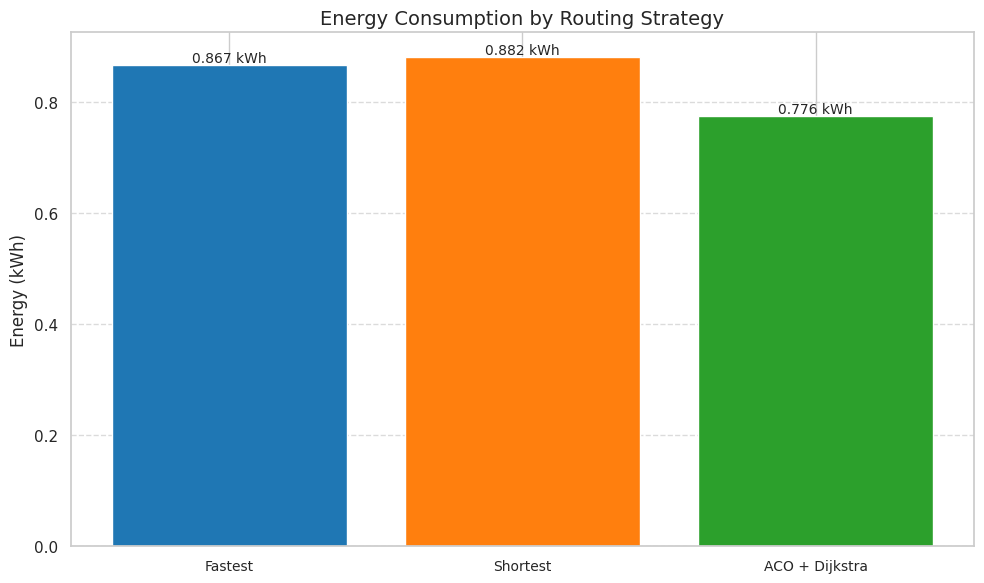

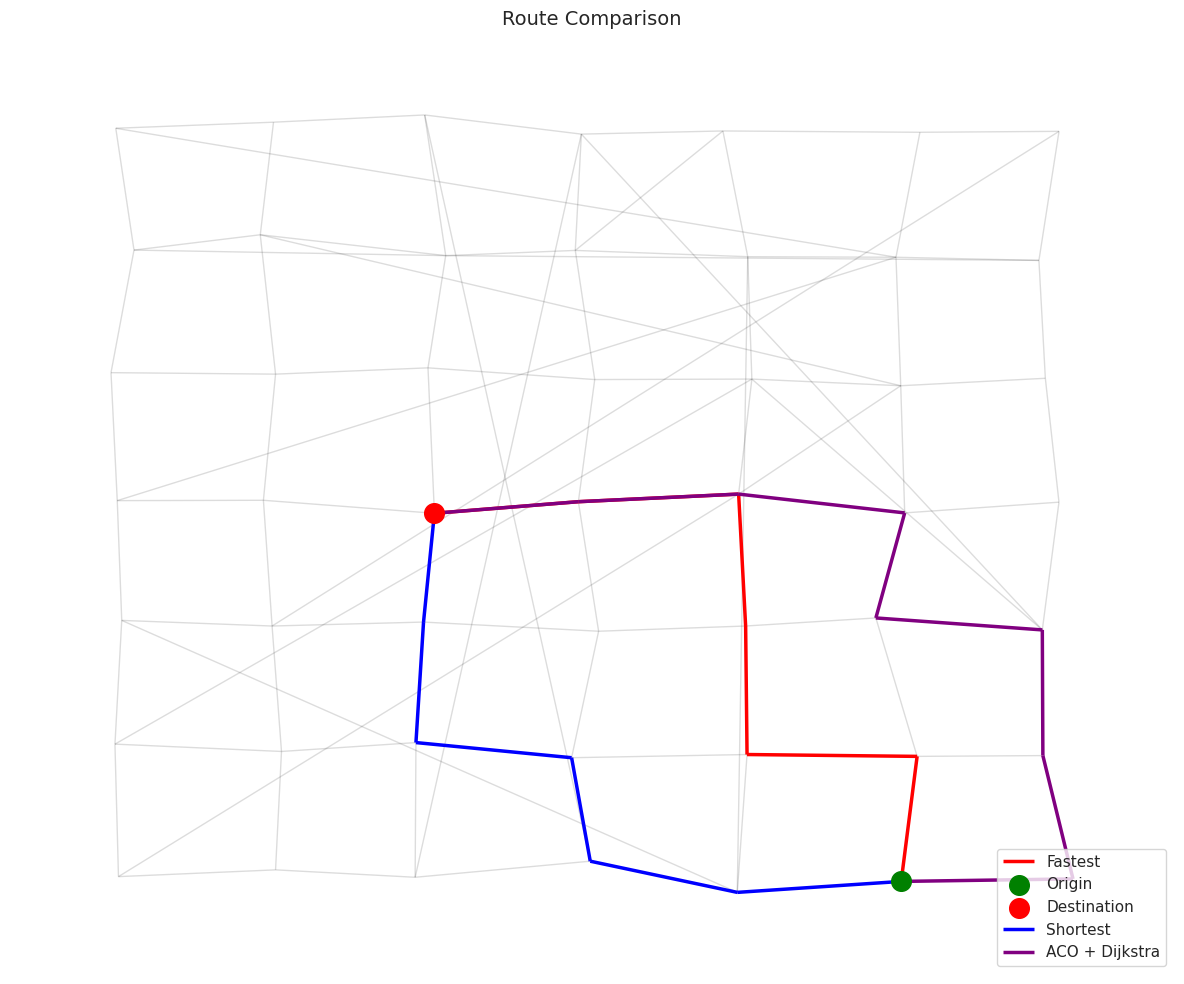

In [46]:
# Run the experiment with the generated road network
experiment_results = run_ant_colony_routing_experiment(city_network, VEHICLE_PARAMETERS, renewable_energy_data)

# Show detailed ACO vs Bellman-Ford comparison
if experiment_results is not None and 'Energy (Bellman-Ford)' in experiment_results['Strategy'].values and 'ACO + Dijkstra' in experiment_results['Strategy'].values:
    bf_energy = experiment_results.loc[experiment_results['Strategy'] == 'Energy (Bellman-Ford)', 'Energy Consumption (kWh)'].values[0]
    aco_energy = experiment_results.loc[experiment_results['Strategy'] == 'ACO + Dijkstra', 'Energy Consumption (kWh)'].values[0]

    improvement = ((bf_energy - aco_energy) / bf_energy) * 100 if bf_energy > 0 else 0

    print("\n--- ACO + Dijkstra vs Bellman-Ford Comparison ---")
    print(f"Bellman-Ford Energy: {bf_energy:.4f} kWh")
    print(f"ACO + Dijkstra Energy: {aco_energy:.4f} kWh")
    print(f"Improvement: {improvement:.2f}%" + (" (ACO better)" if improvement > 0 else " (Bellman-Ford better)"))

    # Compare route lengths
    bf_route = experiment_results.loc[experiment_results['Strategy'] == 'Energy (Bellman-Ford)', 'Route'].values[0]
    aco_route = experiment_results.loc[experiment_results['Strategy'] == 'ACO + Dijkstra', 'Route'].values[0]

    print(f"Bellman-Ford route length: {len(bf_route)} nodes")
    print(f"ACO + Dijkstra route length: {len(aco_route)} nodes")